<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 36px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  LAB-02: LÀM VIỆC VÀ TRỰC QUAN HÓA DỮ LIỆU CHUỖI THỜI GIAN<Title>
</div>

<h2>Nhóm 23</h2>
<h3>Thông tin nhóm:</h3>


<center>

| HỌ TÊN                | MSSV      |
|:------------------    |:--------: |
| Lê Công Đắt     | 20120454  |
| Lê Trần Minh Khuê     | 21120279  |
| Hoàng Trung Nam       | 21120290  |
| Lê Trần Như Ngọc       | 21120296  |
| Lê Thị Minh Phương | 21120533  |

</center>


<h2>Giảng viên hướng dẫn:</h2>

### **Thầy Lê Nhựt Nam**

<h2>Chủ đề:</h2>

## ***Phân tích và trực quan giá cổ phiếu của top 6 ngân hàng có trị thương hiệu tốt nhất Việt Nam***

---


# **Phần C: Khám phá mối quan hệ trong dữ liệu.**
## **C04. Kiểm tra tính dừng của của các time series về giá cổ phiếu và xây dựng các mô hình dự đoán giá cổ phiếu**

#### ***Sơ lược nội dung:***
1. Kiểm tra tính dừng của các time series về giá cổ phiếu.
2. Tìm tính chu kỳ trong các time series về giá cổ phiếu của từng ngân hàng.
3. Thực hiện các phép biến đổi để đưa về time series thỏa mãn tính dừng.
4. Xây dựng mô hình SARIMA và mô hình LSTM để dự đoán giá cổ phiếu.


## **I. Chuẩn bị** 

### 1. Nhập các thư viện

In [2]:
# Nhập các thư viện cần dùng
import numpy as np
import pandas as pd

# Các thư viện để vẽ hình
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Các thư viện stats
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings("ignore")


### 2. Nhập dữ liệu

In [3]:
# Nhập data đã xử lý từ pha B 
full_df = pd.read_csv("../Datasets/full_data_processed.csv ")
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Xem dữ liệu
full_df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,Stock symbol,Bank
0,2018-06-04,10633.7,10028.5,10633.7,10028.5,18000000.0,6.96,VPB,VPBank
1,2018-06-04,44960.0,42837.0,45187.0,42458.0,4900000.0,4.04,VCB,Vietcombank
2,2018-06-04,23343.0,22195.0,23419.5,21735.7,6140000.0,2.69,BID,BIDV
3,2018-06-04,3425.1,3307.0,3425.1,3218.4,112900.0,6.75,AGR,Agribank
4,2018-06-04,20839.3,20429.2,20951.1,20168.3,7570000.0,1.82,CTG,VietinBank


## **II. Phân tích và trực quan hoá.** <a id=”ii-phân-tích-và-trực-quan-hoá″></a>

### **1. Kiểm tra tính dừng của các time series về giá cổ phiếu.**

#### **Thông tin đang quan tâm:**
- Các time series về giá cổ phiếu của từng ngân hàng có thỏa mãn tính dừng hay không?

#### **Hướng tiếp cận:**
- Lấy các time series của thuộc tính `Price` của từng ngân hàng theo thời gian.
- Đánh giá tính dừng bằng cách **quan sát biểu đồ** biểu diễn giá trị của time series theo thời gian.
- Đánh giá tính dừng sử dụng **thống kê mô tả** trên từng đoạn của time series (**chunking**).
- Đánh giá tính dừng sử dụng biểu đồ **histogram** và **normal test** để kiểm tra xấp xỉ phân phối chuẩn.
- Đánh giá tính dừng sử dụng **ADF test**.


In [261]:
# Tạo dictionary chứa các dataframe ứng với từng ngân hàng
grouped_df = full_df.groupby('Bank')
dataframes = {name: group for name, group in grouped_df}

In [262]:
# Định nghĩa hàm lấy dataframe theo tên ngân hàng
# Sắp xếp lại theo Date tăng dần và cho phép tùy chọn kiểu index
def get_bank_df(bankname, date_index=True):
    df = dataframes[bankname]
    df = df.sort_values(by='Date')
    if (date_index==False):
        df.reset_index(drop=True, inplace=True)
    else:
        df.set_index('Date', inplace=True)
    return df

#### **1.1. Khảo sát chi tiết tính dừng của time series về giá cổ phiếu với ngân hàng Agribank.**

Tính dừng (stationarity) là một điều kiện quan trọng đối với dữ liệu time series. Nhiều mô hình dự đoán time series yêu cầu giả định về tính dừng.

- **Tính dừng ngặt** (strict stationarity): Một time series thỏa mãn tính dừng ngặt nếu bất kỳ các time series con bất kỳ của nó có cùng phân phối (không phụ thuộc vào thời gian).

Phát biểu: Cho một quá trình ngẫu nhiên $X(t)$: $t \in T$ được gọi là dừng ngặt nếu với mọi $t_1, t_2,..., t_n \in T$ và $h$ sao cho $t_1+h, t_2+h,...,t_n+h \in T$ thì
$$
    (X(t_1), X(t_2),...,X(t_n)) \overset{D}{=} (X(t_1+h), X(t_2+h),...,X(t_n+h))
$$

với $\overset{D}{=}$ chỉ các phân phối là giống nhau.

> Trên thực tế, tính dừng ngặt thường khó thỏa mãn. Do đó ta định nghĩa một tiêu chuẩn lỏng lẻo hơn về tính dừng sao cho đủ hữu dụng và có thể thỏa mãn được trong thực tế, gọi là tính dừng yếu.

- **Tính dừng yếu** (weak stationarity): Một time series thỏa mãn tính dừng yếu nếu: (1) Giá trị trung bình của các time series con không đổi theo thời gian, (2) phương sai của các time series con không đổi theo thời gian và (3) hiệp phương sai giữa hai time series con chỉ phụ thuộc vào độ trễ giữa chúng.

> Điều kiện (3) nghĩa là hiệp phương sai giữa $X(t)$ và $X(t+h)$ chỉ phụ thuộc vào độ trễ $h$.

Trong câu hỏi này, chúng ta khảo sát tính dừng yếu của các time series về giá cổ phiếu cho từng ngân hàng. Để ngắn gọn, từ đây, chúng ta sẽ gọi **tính dừng** để chỉ tính dừng yếu. Khi đó, ta khảo sát xem time series có thỏa mãn các điều kiện sau đây:
- Giá trị trung bình không đổi theo thời gian (đồng nghĩa với việc không có *xu hướng*). #1
- Phương sai không đổi theo thời gian (hiện tượng phương sai thay đổi được gọi là *heteroskedasticity*). #2
- Cấu trúc hiệp phương sai không đổi theo thời gian (chỉ phụ thuộc vào độ trễ giữa hai time series con). #3

Có nhiều phương pháp để kiểm tra tính dừng của một time series, mỗi phương pháp có một ưu nhược điểm riêng và có những trường hợp áp dụng khác nhau. Để kết quả đánh giá đáng tin cậy, ta cần kết hợp nhiều cách khác nhau. Dưới đây, chúng ta sẽ khảo sát tính dừng của time series với 4 kỹ thuật bao gồm:
- **Run-sequence Plots**: Trực quan time series cùng rolling mean, rolling variance và đánh giá xem sự thay đổi của chúng theo thời gian.
- **Chunking Summary Statistics**: Chia time series thành các phần nhỏ bằng nhau (chunking) để kiểm tra sự thay đổi giá trị trung bình và phương sai.
- **Histogram Plots**: Vẽ biểu đồ histogram của time series để đánh giá sự xấp xỉ của time series về phân phối chuẩn.
- **Normal Test**: Sử dụng kiểm định thống kê để kiểm tra time series có tuân theo phân phối chuẩn hay không.
- **Augmented Dickey-Fuller Test**: Sử dụng kiểm định ADF test để kiểm tra tính dừng của time series.

Các định nghĩa và phương pháp được sử dụng để trả lời cho câu hỏi này được tham khảo chủ yếu từ handbook [Time series analysis with Python](https://filippomb.github.io/python-time-series-handbook/notebooks/00/intro.html).

In [263]:
AGR_df = get_bank_df(bankname='Agribank', date_index=True)
AGR_df.head(2)

,Price,Open,High,Low,Vol.,Change %,Stock symbol,Bank
Date,,,,,,,,
2018-06-04,3425.1,3307.0,3425.1,3218.4,112900.0,6.75,AGR,Agribank
2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR,Agribank


##### **1.1.1. Run-sequence Plot**
Trực quan time series cùng rolling mean, rolling variance và đánh giá xem sự thay đổi của chúng theo thời gian. 

Ở đây, ta chọn `window`=30, nghĩa là quan sát liên tục các time series con dài 30 ngày để tính rolling mean và rolling std. Phương pháp này tương tự như cách hoạt động của Simple Moving Average đã được trình bày ở notebook trước. 

Đối với phương pháp run-sequence plot này, ta đánh giá tính dừng một cách thủ công.

In [264]:
# Định nghĩa hàm Run-sequence plot 
def plot(series, series_name, plots_mean_std=True):
    plt.figure(figsize=(14, 4))
    plt.plot(series, color='tab:blue',label='Series')

    if (plots_mean_std):
        # Tính rolling mean và rolling std
        rolmean = series.rolling(window=30).mean()
        rolstd = series.rolling(window=30).std()
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='darkorange', label = 'Rolling Std')
        plt.legend(loc='best')

    plt.title(f'{series_name} Over Time')
    plt.grid(); 

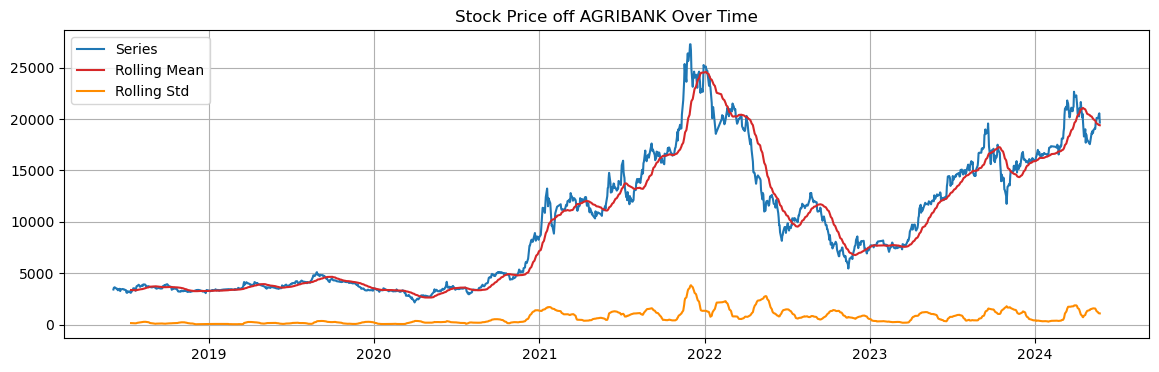

In [265]:
plot(series=AGR_df['Price'], series_name='Stock Price off AGRIBANK')

**Nhận xét:**
- Từ đường màu xanh biểu diễn time series, ta thấy giá trị của time series thay đổi theo thời gian và có mức độ thay đổi khác nhau nhiều trong từng giai đoạn. 
- Đồng thời (cụ thể hơn), đường màu đỏ biểu diễn rolling mean thay đổi nhiều cho thấy giá trị trung bình của các time series con thay đổi theo thời gian; đường màu cam biểu diễn rolling std thì thay đổi không nhiều (nếu xét trên cùng khoảng giá trị), tuy nhiên vẫn có thay đổi - trước năm 2021 độ lệch chuẩn không đổi nhưng sau năm 2021 thì có thay đổi.
- Ta có thể đánh giá cảm tính rằng giá trị trung bình có thay đổi theo thời gian (vi phạm điều kiện #1), phương sai có thay đổi, nhưng ta không biết sự thay đổi này có ý nghĩa hay không (có thể vi phạm điều kiện #2 hoặc không). Với đánh giá này, time series trên ***`không` thỏa mãn tính dừng***.
- Trong đánh giá này, có những điều kiện ta chưa thể khẳng định chắc chắn là có bị vi phạm hay không. Do đó cần kết hợp thêm những phương pháp khác. Tuy nhiên, như đã đề cập, các phương pháp dù là tự động hay thủ công đều có ưu nhược điểm riêng, và việc đánh giá thủ công trong phương pháp này vẫn là một điều cần thiết.

##### **1.1.2. Chunking Summary Statistics**
Chia time series thành các phần nhỏ bằng nhau (chunking) để kiểm tra sự thay đổi giá trị trung bình và phương sai. Phương pháp này đòi hỏi sự đánh giá thủ công.

In [266]:
def summary_statistics(series, series_name):
    print(f'Statistical Chunking Summary of {series_name}')
    if len(series) >= 10:
        # Chia time series thành 10 chunk
        chunks = np.array_split(series, 10)
        
        # Tính giá trị trung bình và phương sai trên từng chunk
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [267]:
summary_statistics(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK')

Statistical Chunking Summary of Stock Price of AGRIBANK
Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3475.8	 | 4.8106e+04
 2	 | 3735.4	 | 8.0827e+04
 3	 | 3835.9	 | 3.3749e+05
 4	 | 3591.1	 | 5.8736e+05
 5	 | 9568.3	 | 7.3838e+06
 6	 | 1.7217e+04	 | 1.7529e+07
 7	 | 1.5749e+04	 | 2.4969e+07
 8	 | 8435.8	 | 3.1573e+06
 9	 | 1.3484e+04	 | 8.4388e+06
10	 | 1.7431e+04	 | 5.9252e+06


In [268]:
print(f"Giá trị trung bình của chunk 10 / Giá trị trung bình của chunk 1 = {1.7431e+04/3475.8}")

Giá trị trung bình của chunk 7 / Giá trị trung bình của chunk 1 = 5.014960584613614


In [269]:
print(f"Phương sai của chunk 7 / Phương sai của chunk 1 = {2.4969e+07/4.8106e+04}")

Phương sai của chunk 7 / Phương sai của chunk 1 = 519.0412838315386


**Nhận xét:**
- Giá trị trung bình thay đổi nhiều (ví dụ giá trị trung bình của chunk 10 lớn gấp 5 lần giá trị trung bình của chunk 1). Giá trị hiệp phương sai cũng thay đổi nhiều (ví dụ hiệp phương sai của chunk 7 lớn gấp 500 lần hiệp phương sai của chunk 1).
- Ta có thể đánh giá một cách cảm tính rằng time series trên ***`không` thỏa mãn tính dừng***.

##### **1.1.3. Histogram Plot**
Vẽ biểu đồ histogram của time series để đánh giá sự xấp xỉ của time series về phân phối chuẩn. Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán rằng giá trị trung bình và phương sai của các time series con là không đổi theo thời gian. 

Phương pháp này yêu cầu sự đánh giá thủ công.

In [270]:
def histogram_plot(series, series_name):
    plt.figure(figsize=(10, 6))
    plt.hist(series, bins=100, edgecolor='black')
    plt.title(f'Histogram of {series_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

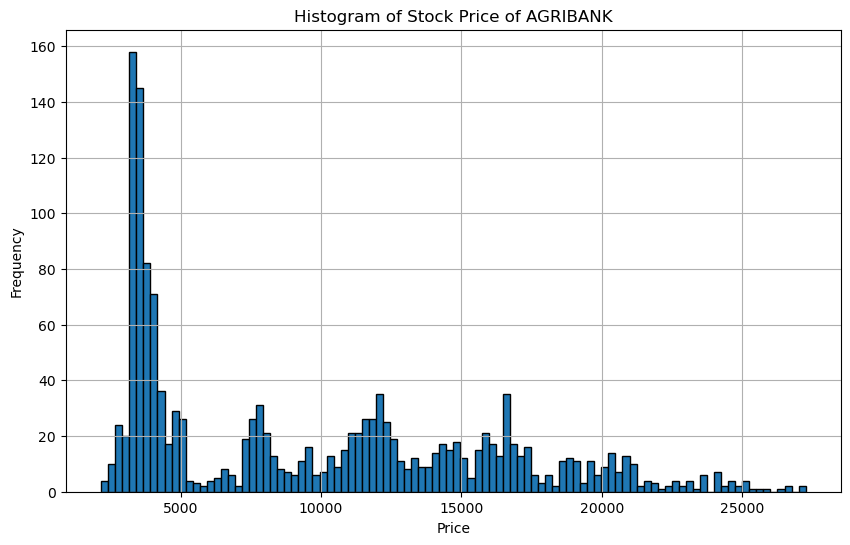

In [271]:
histogram_plot(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK')

**Nhận xét:**
- Dựa vào biểu đồ histogram, ta thấy time series khác xa so với phân phối chuẩn. 
- Từ quan sát này, ta có thể kết luận rằng time series trên ***`không` thỏa mãn tính dừng***.
- Ở phương pháp này, sự đánh giá tính dừng có phần dễ dàng hơn thông qua điều kiện suy diễn là xấp xỉ phân phối chuẩn. Ta có sử dụng kiểm định **normal test** để đánh giá sự khác biệt giữa phân phối của time series so với phân phối chuẩn.

##### **1.1.4. Normal Test**
Sử dụng kiểm định thống kê để kiểm tra time series có xấp xỉ phân phối chuẩn hay không. Ở đây, ta sử dụng hàm kiểm định `normaltest` của thư viện [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html). Hàm `normaltest` cho phép kiểm tra một mẫu có khác biệt so với phân phối chuẩn hay không. Hàm dựa trên kiểm định của D'Agostino and Pearson's kết hợp độ lệch (skew) và độ nhọn (kurtosis).

Giả thuyết $H_0$: Dữ liệu tuân theo phân phối chuẩn.

In [272]:
def normal_test(series, series_name, significance_level=0, prints=True):
    k2, pvalue = normaltest(series)

    # In chi tiết kết quả kiểm định nếu được yêu cầu
    if (prints == True):
        print(f"Normality Test Result for {series_name}:")
        print(f"Statistic: {k2:.4f}")
        print(f"P-value: {pvalue:.4f}")

        # In kết luận nếu mức ý nghĩa thống kê được cung cấp
        if significance_level > 0:
            if (pvalue < significance_level):
                print(f"The null hypothesis of normality is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of normality CANNOT BE REJECTED (significant level {significance_level}).")
    
    # Trả về kết quả 
    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [273]:
_ = normal_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

Normality Test Result for Stock Price of AGRIBANK:
Statistic: 180.1440
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).


**Nhận xét:**
- Giá trị `p-value` rất thấp xấp xỉ 0, do đó ta dễ dàng bác bỏ giả thuyết $H_0$. Ta kết luận rằng time series không xấp xỉ phân phối chuẩn, do đó ***không thỏa mãn tính dừng***.

##### **1.1.5. Augmented Dickey-Fuller (ADF) Test**
**Kiểm định ADF** kiểm tra sự có mặt của **unit root** trong một chuỗi thời gian. Unit root là một thuật ngữ mô tả một điều kiện cụ thể trong biểu diễn tự hồi quy (autoregressive) của một chuỗi thời gian, chỉ ra rằng chuỗi này không thỏa mãn dừng.

Một time series có unit root thì nó không thỏa mãn tính dừng. Ý tưởng cơ bản của kiểm định ADF là đánh giá xem các giá trị trong quá khứ của một time series có giúp dự đoán giá trị hiện tại hay không (tự hồi quy) thông qua sự có mặt của unit root. 

**Giả thuyết $H_0$: Time series có chứa unit root, do đó không thỏa mãn tính dừng.**

Ở đây, ta sử dụng hàm `adfuller` của thư viện [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) với phương pháp xác định độ trễ tự động là `AIC`. 


**Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.**

In [274]:
def adf_test(series, series_name, significance_level=0, prints=True):
    adf, pvalue, _, _, _, _ = adfuller(series, autolag='AIC')

    # In chi tiết kết quả kiểm định nếu được yêu cầu
    if (prints == True):
        print(f"ADF Test Result for {series_name}:")
        print("ADF Statistic:", adf)
        print("p-value:", pvalue)

        # In kết luận nếu mức ý nghĩa thống kê được cung cấp
        if (significance_level > 0):
            if pvalue < significance_level:
                print(f"The null hypothesis of non-stationarity is REJECTED (significant level {significance_level}).")
            else:
                print(f"The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level {significance_level}).")

    # Trả về kết quả 
    if (pvalue < significance_level): return "Rejected"
    else: return "Cannot be rejected"

In [275]:
_ = adf_test(series=AGR_df['Price'], series_name='Stock Price of AGRIBANK', significance_level=0.05, prints=True)

ADF Test Result for Stock Price of AGRIBANK:
ADF Statistic: -1.2487299252705506
p-value: 0.652290190381921
The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level 0.05).


**Nhận xét:**
- Kết quả kiểm định cho thấy `p-value` khá cao, do đó ta khó bác bỏ giả thuyết $H_0$. Với mức ý nghĩa 0.05 ta không thể bác bỏ giả thuyết $H_0$, do đó ta kết luận rằng time series ***không thỏa mãn tính dừng***. 

##### **Nhận xét chung:**
- Kết quả của cả 5 phương pháp trên đều đưa đến kết luận rằng ***time series về giá cổ phiếu của ngân hàng Agribank `không` thỏa mãn tính dừng***. 
- **Các phương pháp kiểm định** như normal test và ADF test có thể không cần sự đánh giá chi tiết từ con người, do đó chính xác và công bằng hơn, tuy nhiên bởi vì các time series thường khó thỏa mãn tính dừng, do đó việc đánh giá bằng kiểm định khá nghiêm ngặt và có thể bỏ qua các trường hợp có thể chấp nhận được tính dừng một cách tương đối. Ngoài ra, kiểm định ADF cũng có những trường hợp ngoại lệ (như đã trình bày) có thể đưa ra kết quả đánh giá sai lệch. 
- **Các phương pháp thủ công** như trực quan (run-sequence plot, histogram plot), chunking summary statistics với sự tham gia của con người cho phép có sự điều chỉnh ngưỡng chấp nhận, tuy nhiên nó cũng có hạn chế về sự cảm tính và chủ quan. Do đó, cần kết hợp nhiều phương pháp để có thể đánh giá một cách toàn diện và chính xác. 
- Tuy nhiên, đối với time series về giá cổ phiếu của ngân hàng Agribank ở trên, ta dễ dàng đánh giá tính dừng bởi vì nó vi phạm những điều kiện dễ phát hiện như giá trị trung bình thay đổi. Do đó ta có thể đơn giản chọn lựa một trong các phương pháp để đánh giá. 

#### **1.2. Đánh giá nhanh về tính dừng của các time series giá cổ phiếu của tất cả các ngân hàng.**

Ta đã đánh giá và nhận xét chi tiết về tính dừng của time series về giá cổ phiếu của ngân hàng Agribank trong phần trên (1.1). Ở phần này, ta chỉ đánh giá nhanh và đưa ra kết luận vì nhận xét khá tương tự như đối với phần 1.1.

**Sub-sequence plots**

In [276]:
def plot_all(plots_mean_std=True):
    num_plots = len(dataframes)
    cols = 3
    rows = (num_plots + 1) // cols 

    plt.figure(figsize=(15, 3 * rows))

    for i, series_name in enumerate(dataframes.keys(), 1):
        series = get_bank_df(series_name)['Price']
        plt.subplot(rows, cols, i)
        plt.plot(series, color='tab:blue',label='Series')
        plt.title(series_name)
        plt.grid()

        if (plots_mean_std):
            rolmean = series.rolling(window=30).mean()
            plt.plot(rolmean, color='tab:red', label='Rolling Mean')
            rolstd = series.rolling(window=30).std()
            plt.plot(rolstd, color='black', label = 'Rolling Std')
            plt.legend(loc='best')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.4)  
    plt.suptitle('Stock Price of Banks Over Time')
    plt.show()

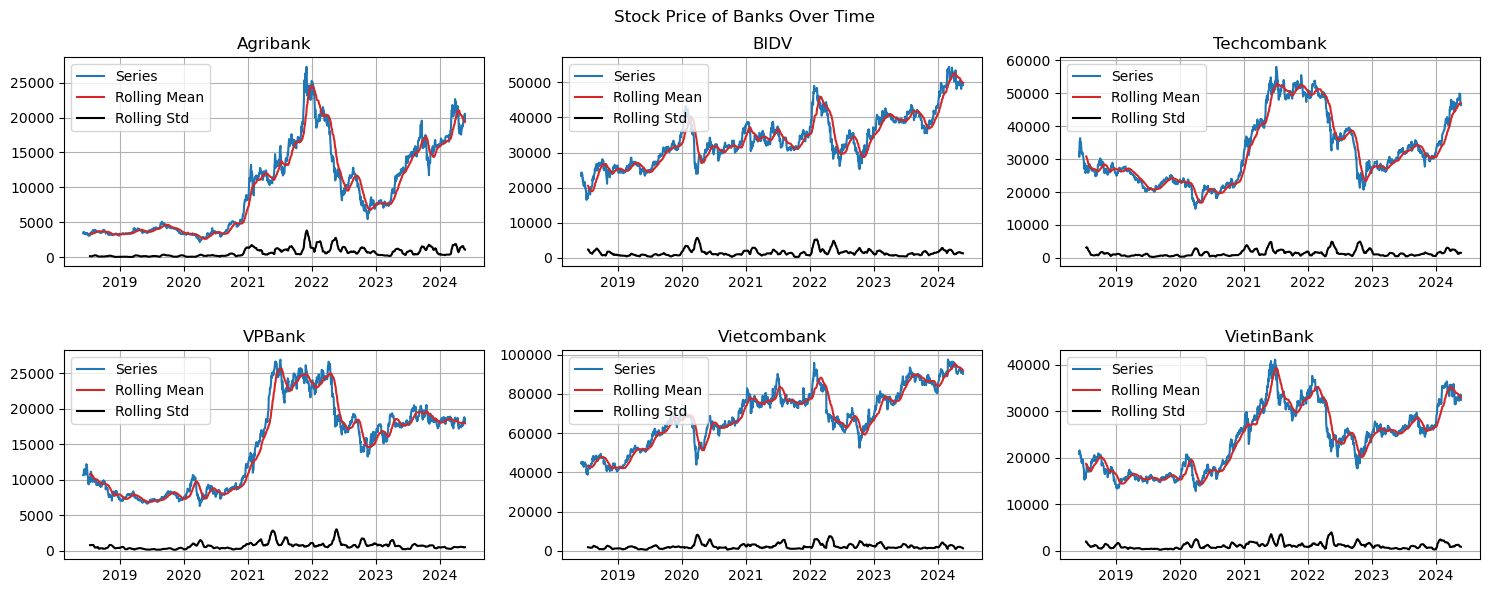

In [277]:
plot_all()

Từ các sub-sequence plot, ta thấy tất cả các time series đều có giá trị trung bình và phương sai thay đổi. 

**Histogram plots**

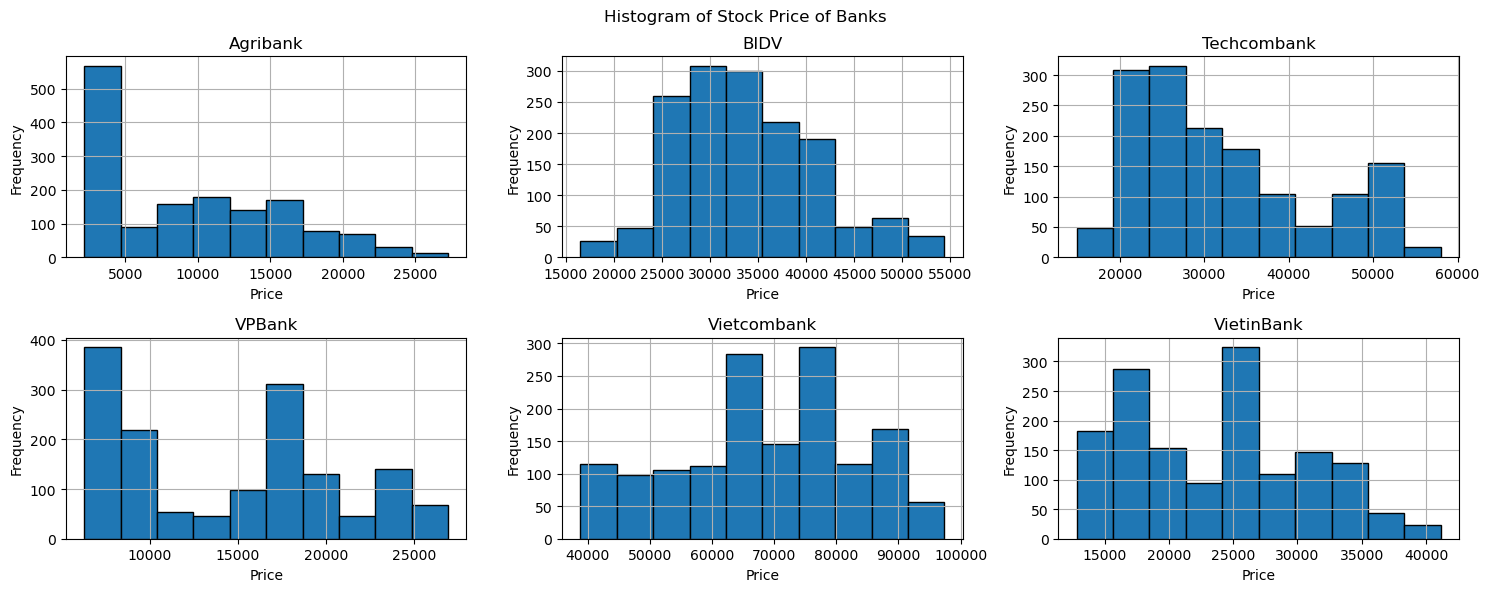

In [278]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, series_name in enumerate(dataframes.keys(), 1):
    series = get_bank_df(series_name)['Price']

    plt.subplot(rows, cols, i)
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(series_name)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.4)  
plt.suptitle('Histogram of Stock Price of Banks')
plt.show()

Từ các biểu đồ histogram, ta thấy phân phối của time series ứng với giá cổ phiếu của ngân hàng BIDV gần với phân phối chuẩn hơn cả (nhưng có vẻ vẫn không đủ xấp xỉ), phân phối của các time series còn lại có sự khác biệt nhiều so với phân phối chuẩn. Tính dừng của time series ứng với ngân hàng BIDV chưa kết luận ngay được, nhưng với các ngân hàng còn lại ta có thể nhận xét rằng chúng không thỏa mãn tính dừng.

**Normal Test và ADF Test**

In [279]:
sig_level = 0.01
results = []

for series_name in dataframes.keys():
    series = get_bank_df(series_name)['Price']
    normal_result = normal_test(series, series_name, significance_level=sig_level, prints=False)
    adf_result = adf_test(series, series_name, significance_level=sig_level, prints=False)
    results.append([series_name, normal_result, adf_result])

print(f"Normal Test and ADF Test Results for Stock Price (significant level {sig_level}):")
pd.DataFrame(results, columns=['Price Series', 'Normal', 'Non-stationary'])

Normal Test and ADF Test Results for Stock Price (significant level 0.01):


,Price Series,Normal,Non-stationary
0,Agribank,Rejected,Cannot be rejected
1,BIDV,Rejected,Cannot be rejected
2,Techcombank,Rejected,Cannot be rejected
3,VPBank,Rejected,Cannot be rejected
4,Vietcombank,Rejected,Cannot be rejected
5,VietinBank,Rejected,Cannot be rejected


Từ bảng kết quả trên, ta thấy với mức ý nghĩa 0.01 thì:
- Đối với normal test, giả thuyết $H_0$ bị bác bỏ đối với tất cả các time series, tức là bác bỏ giả thuyết rằng các time series tuân theo phân phối chuẩn. Do đó, các time series không thỏa mãn tính dừng.
- Đối với adf test, giả thuyết $H_0$ không thể bị bác bỏ đối với tất cả các time series, tức là không thể bác bỏ giả thuyết rằng các time series không thỏa mãn tính dừng. Do đó, các time series không thỏa mãn tính dừng.

#### **Nhận xét chung:**
- Với kết quả từ các phương pháp trên, ta kết luận rằng ***tất cả các time series ứng với giá cổ phiếu của tất cả 6 ngân hàng đều `không` thỏa mãn tính dừng***. 
- Việc đánh giá tính dừng của các time series này khá đơn giản vì giá cổ phiếu biến động nhiều theo thời gian, do đó các điều kiện dễ phát hiện như giá trị trung bình và phương sai thay đổi.
- Tuy nhiên, có thể nhận xét rằng pattern của các time series này không rõ ràng (nguyên nhân là bởi vì giá cổ phiếu bị tác động bởi rất nhiều yếu tố khác nhau như kết quả kinh doanh của công ty, nền kinh tế, quy luật cung cầu và các thông tin liên quan...). **Xu hướng** của các time series thay đổi nhiều lần với các mức độ khác nhau trong từng giai đoạn. **Tính chu kỳ** của time series không rõ ràng. 

### **2. Tìm tính chu kỳ trong các time series về giá cổ phiếu của từng ngân hàng?**
##### **Thông tin đang quan tâm:**
- Time series về giá cổ phiếu của từng ngân hàng có tính chu kỳ hay không?
- Nếu có, độ dài của mỗi chu kỳ là bao nhiêu?

##### **Hướng tiếp cận:**
- Lấy ra time series về giá cổ phiếu của ngân hàng BIDV.
- Sử dụng kỹ thuật Fast Fourier Transform để tìm chu kỳ.
- Quan sát biểu đồ của time series và đánh giá tính phù hợp của độ dài chu kỳ tìm được.

#### **2.1. Các thành phần của một time series**
Một time series bao gồm có 3 thành phần: 
- **Xu hướng (trend):** Hướng chung của time series (tăng, giảm, không đổi).
- **Chu kỳ (seasonality):** Dao động có chu kỳ của time series lặp lại sau một khoảng thời gian đều đặn (hàng ngày, hàng tháng, hàng quý, hàng năm...).
- **Phần dư (residuals):** Phần dao động ngẫu nhiên còn lại sau khi loại bỏ xu hướng và chu kỳ ra khỏi time series.

#### **2.2. Kỹ thuật Fast Fourier Transform**

Biến đổi Fourier hay **Fourier Transform** là kỹ thuật phân tích tín hiệu thành tổng các hàm sin khác nhau. Với $f(t)$ là tín hiệu theo thời gian $t$ và $\mathcal{F}(\omega)$ là Fourier Transform của $f(t)$ theo tần số góc $\omega = 2\pi f$:
$$
\mathcal{F}(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt.
$$

Phép biến đổi Fourier nghịch đảo hay **Inverse Fourier Transform** có công thức:
$$
f(t) = \int_{-\infty}^{\infty} \mathcal{F}(\omega) e^{i\omega t} d\omega.
$$

Phép biến đổi Fourier rời rạc **Discrete Fourier Transform** (DFT) thực hiện biến đổi Fourier đối với một dãy hữu hạn các mẫu tín hiệu cách đều nhau và sắp xếp theo tần số. **Fast Fourier Transform** (FFT) là một thuật toán giúp tính DFT và Inverse DFT một cách hiệu quả với độ phức tạp $\mathcal{O}(NlogN)$ thay vì $\mathcal{O}(N^2)$.

Ta sử dụng hàm `fft` của thư viện [scipy](https://docs.scipy.org/doc/scipy/tutorial/fft.html) để tìm thành phần tuần hoàn, tức chu kỳ của các time series.


In [280]:
from scipy.fft import fft

def fft_analysis(signal, signal_name="signal"):
    # Thực hiện Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Loại bỏ các tần số góc âm và sắp xếp 
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    print(f"Fast Fourier Transform result of {signal_name}:")
    print(f"Signal Length: {len(signal)}")

    # Xác định dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Xác định độ dài chu kỳ
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units\n")
    
    return dominant_period, positive_frequencies, magnitudes

In [281]:
for i, series_name in enumerate(dataframes.keys(), 1):
    series = get_bank_df(series_name)['Price']
    signal_name = series_name + " Stock Price"
    _,_,_ = fft_analysis(signal=series.values, signal_name=signal_name)

Fast Fourier Transform result of Agribank Stock Price:
Signal Length: 1494
Dominant Frequency: 0.001
Dominant Period: 747.00 time units

Fast Fourier Transform result of BIDV Stock Price:
Signal Length: 1494
Dominant Frequency: 0.004
Dominant Period: 249.00 time units

Fast Fourier Transform result of Techcombank Stock Price:
Signal Length: 1493
Dominant Frequency: 0.001
Dominant Period: 746.50 time units

Fast Fourier Transform result of VPBank Stock Price:
Signal Length: 1494
Dominant Frequency: 0.001
Dominant Period: 747.00 time units

Fast Fourier Transform result of Vietcombank Stock Price:
Signal Length: 1494
Dominant Frequency: 0.002
Dominant Period: 498.00 time units

Fast Fourier Transform result of VietinBank Stock Price:
Signal Length: 1494
Dominant Frequency: 0.001
Dominant Period: 747.00 time units



In [282]:
print(f"Độ dài chu kỳ ứng với ngân hàng Agribank, Techcombank, VPBank, VietinBank: {747*12/365} tháng")
print(f"Độ dài chu kỳ ứng với ngân hàng Vietcombank: {498*12/365} tháng")
print(f"Độ dài chu kỳ ứng với ngân hàng BIDV: {249*12/365} tháng")

Độ dài chu kỳ ứng với ngân hàng Agribank, Techcombank, VPBank, VietinBank: 24.55890410958904 tháng
Độ dài chu kỳ ứng với ngân hàng Vietcombank: 16.372602739726027 tháng
Độ dài chu kỳ ứng với ngân hàng BIDV: 8.186301369863013 tháng


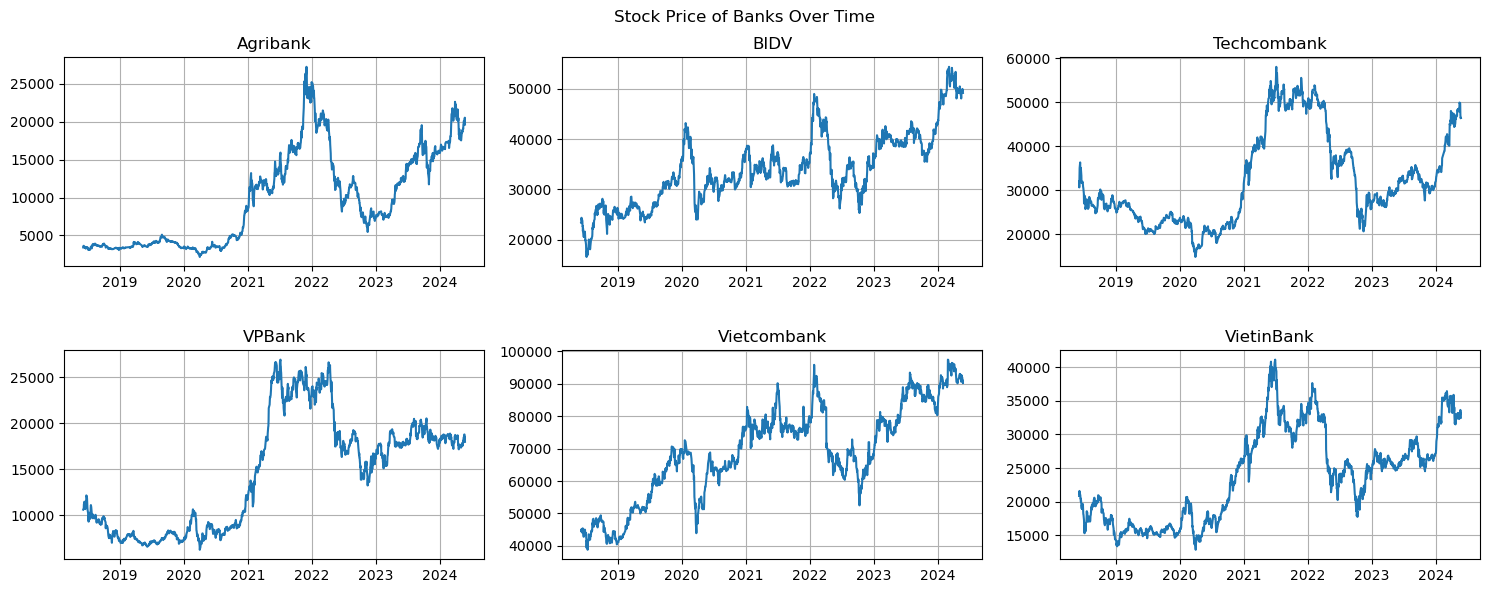

In [283]:
plot_all(plots_mean_std=False)

#### **Nhận xét chung:**
- Đánh giá kết quả của FFT:
    - Time series về giá cổ phiếu của các ngân hàng Agribank, Techcombank, VPBank, VietinBank có **chu kỳ dài**, độ dài mỗi chu kỳ là **747 ngày** tức khoảng 2 năm.
    - Time series về giá cổ phiếu của ngân hàng Vietcombank có **chu kỳ tương đối dài**, độ dài mỗi chu kỳ là **498 ngày** tức khoảng hơn 16 tháng.
    - Time series về giá cổ phiếu của ngân hàng BIDV có **chu kỳ ngắn nhất** trong tất cả 6 ngân hàng, độ dài mỗi chu kỳ là **249 ngày** tức khoảng 8 tháng.
- Đối chiếu với biểu đồ biểu diễn time series:
    - Các time series ứng với 4 ngân hàng Agribank, Techcombank, VPBank, VietinBank có một đặc điểm chung: chia thành 3 giai đoạn, mỗi gian đoạn ứng với khoảng 2 năm, trong đó giai đoạn thứ 2 và thứ 3 có sự tương đồng về pattern. Có thể đây là sự tuần hoàn hay tính chu kỳ đã được phát hiện bởi FFT.
    - Time series ứng với ngân hàng Vietcombank có thể chia thành 3 giai đoạn có sự tương đồng về pattern: xu hướng tăng ở phần lớn các giá trị trong giai đoạn đó và giảm đột ngột ở cuối giai đoạn. 
    - Time series ứng với ngân hàng BIDV có thể chia thành nhiều giai đoạn hơn, trong đó mỗi giai đoạn cũng có sự tương đồng nhất định về pattern.
    - Ta đánh giá **kết quả phân tích chu kỳ của FFT là tương đối phù hợp**.


### **3. Thực hiện các phép biến đổi để đưa về time series thỏa mãn tính dừng.**

##### **Thông tin đang quan tâm:**
- Thử nghiệm sử dụng các kỹ thuật phân tích, biến đổi để time series thỏa mãn tính dừng.
- Kiểm tra tính dừng của time series đã biến đổi.

##### **Hướng tiếp cận:**
- Lấy ra time series về giá cổ phiếu `Price` của ngân hàng BIDV.
- Sử dụng các kỹ thuật biến đổi: **Additive decomposition** (phân tích cộng), **Multiplicative decomposition** (phân tích nhân), **Differencing**, **Biến đổi log**, **Seasonal differencing**.
- Kiểm tra tính dừng của time series đã biến đổi một cách tương đối bằng cách đánh giá xấp xỉ **phân phối chuẩn**.


Ở mục này, ta thực hiện biến đổi time series sử dụng một số các phương pháp được đề cập trong handbook [Python Time Series Analysis](https://filippomb.github.io/python-time-series-handbook/notebooks/01/introduction_to_time_series.html) được trình bày trong bảng sau đây:

| Transformation       | Effect                 |
|----------------------|------------------------|
| Subtract trend       | Constant mean          |
| Apply log            | Constant variance      |
| Differencing         | Remove autocorrelation |
| Seasonal differencing| Remove periodic component|


In [284]:
BID_df = get_bank_df(bankname='BIDV')

In [285]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

def seas_decomp_plots(series, decomposition, suptitle="Decomposition Plot"):
    _, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(20, 5))
    axes[0][0].plot(series, label='Original')
    axes[0][0].legend(loc='upper left')
    axes[0][1].plot(decomposition.trend, label='Trend')
    axes[0][1].legend(loc='upper left')
    axes[1][0].plot(decomposition.seasonal, label='Seasonality')
    axes[1][0].legend(loc='upper left')
    axes[1][1].plot(decomposition.resid, label='Residuals')
    axes[1][1].legend(loc='upper left')
    plt.suptitle(suptitle)
    plt.show()

#### **3.1. Additive Decomposition**

Phân tích cộng, hay **Additive Decomposition** của một time series là phép phân tích time series $X(t)$ thành tổng:
$$
X(t) = T(t) + S(t) + R(t)
$$

với $T(t)$ là xu hướng, $S(t)$ là chu kỳ và $R(t)$ là phần dư (residuals).

In [286]:
def drop_na(x):
    return x[~np.isnan(x)]

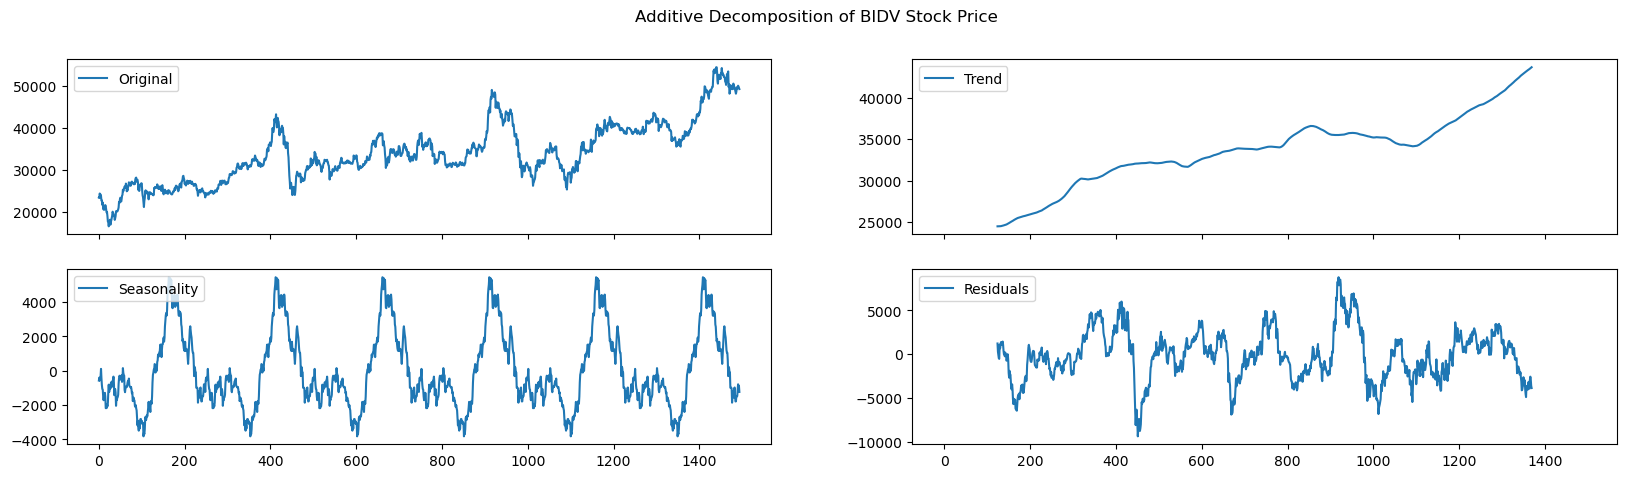

In [287]:
# Thực hiện Additive decomposition
BID_signal = BID_df['Price'].values

additive_decomposition = seasonal_decompose(x=BID_signal, model='additive', period=249)
seas_decomp_plots(BID_signal, additive_decomposition, suptitle="Additive Decomposition of BIDV Stock Price")
additive_residuals = drop_na(additive_decomposition.resid)

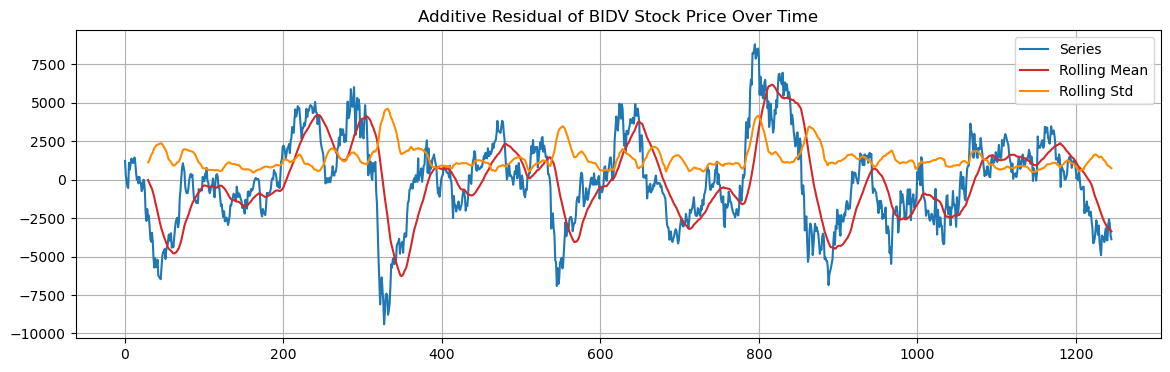

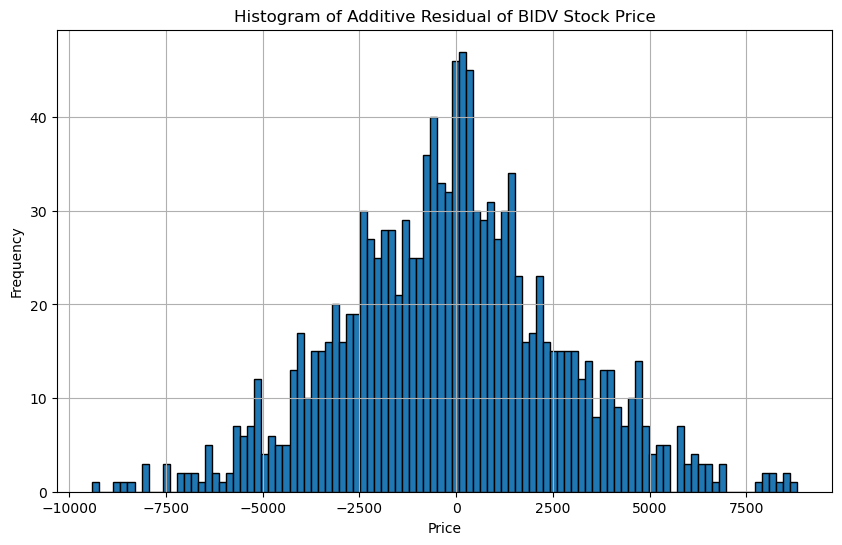

Normality Test Result for Additive Residual of BIDV Stock Price:
Statistic: 4.4794
P-value: 0.1065
The null hypothesis of normality CANNOT BE REJECTED (significant level 0.05).

ADF Test Result for Additive Residual of BIDV Stock Price:
ADF Statistic: -4.832110224523031
p-value: 4.719393754567889e-05
The null hypothesis of non-stationarity is REJECTED (significant level 0.05).


In [288]:
plot(series=pd.Series(additive_residuals), series_name='Additive Residual of BIDV Stock Price')
histogram_plot(series=additive_residuals, series_name='Additive Residual of BIDV Stock Price')

_ = normal_test(additive_residuals, 'Additive Residual of BIDV Stock Price', significance_level=0.05)
print()
_ = adf_test(additive_residuals, 'Additive Residual of BIDV Stock Price', significance_level=0.05)

**Nhận xét:** Về phần dư sau khi phân tích cộng (additive decomposition)
- Biểu đồ **sequence plot**: Tính ngẫu nhiên thấp, giá trị trung bình thay đổi nhiều, phương sai thay đổi ít theo thời gian.
- Biểu đồ **histogram**: Tương đối xấp xỉ phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value` không quá thấp; với mức ý nghĩa 0.05 ta không thể bác bỏ giả thuyết về phân phối chuẩn. Tạm kết luận: xấp xỉ phân phối chuẩn, nên thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` rất thấp; dễ dàng bác bỏ giả thuyết về tính không dừng (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: thỏa mãn tính dừng.
- Kết hợp các đánh giá trên, ta kết luận ***phần dư sau khi áp dụng phép phân tích cộng của time series giá cổ phiếu của ngân hàng BIDV `có` thỏa mãn tính dừng***.

#### **3.2. Multiplicative Decomposition**

Phân tích nhân, hay **Multiplicative Decomposition** của một time series là phép phân tích time series $X(t)$ thành tích:
$$
X(t) = T(t) . S(t) . R(t)
$$

với $T(t)$ là xu hướng, $S(t)$ là chu kỳ và $R(t)$ là phần dư (residuals).

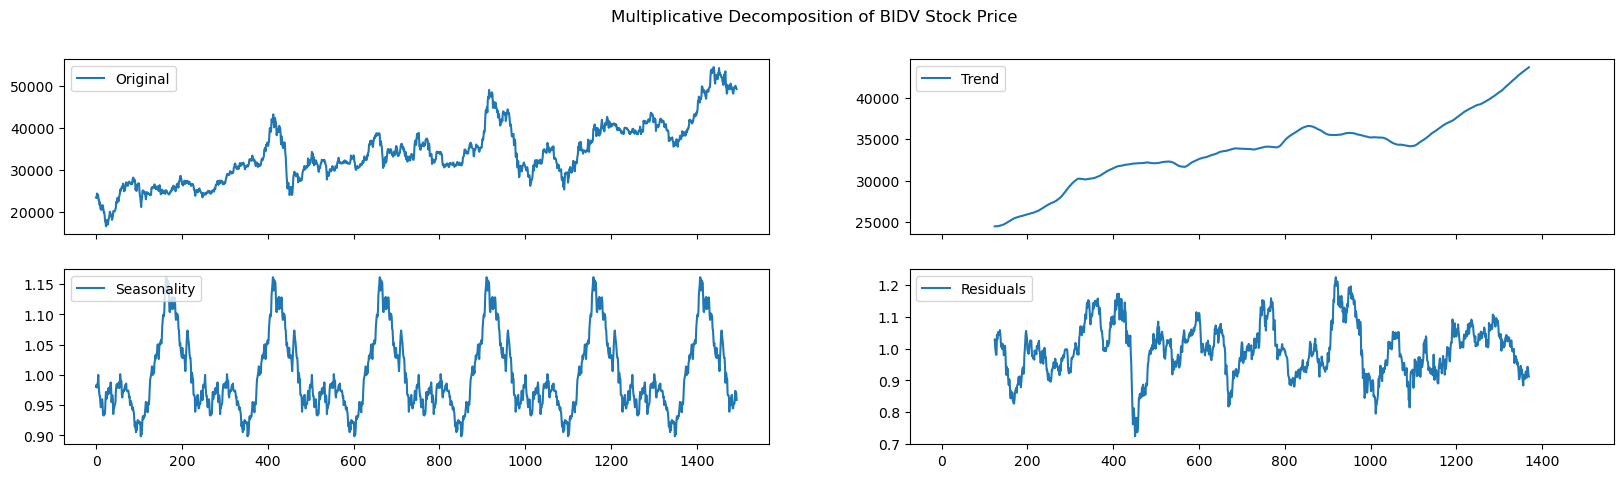

In [289]:
# Thực hiện Multiplicative decomposition
BID_signal = BID_df['Price'].values

multiplicative_decomposition = seasonal_decompose(x=BID_signal, model='multiplicative', period=249)
seas_decomp_plots(BID_signal, multiplicative_decomposition, suptitle="Multiplicative Decomposition of BIDV Stock Price")
multiplicative_residuals = drop_na(multiplicative_decomposition.resid)

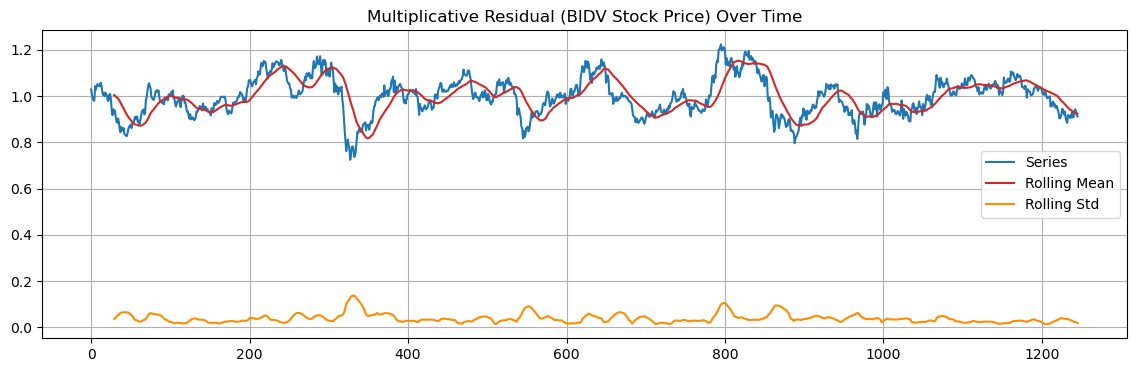

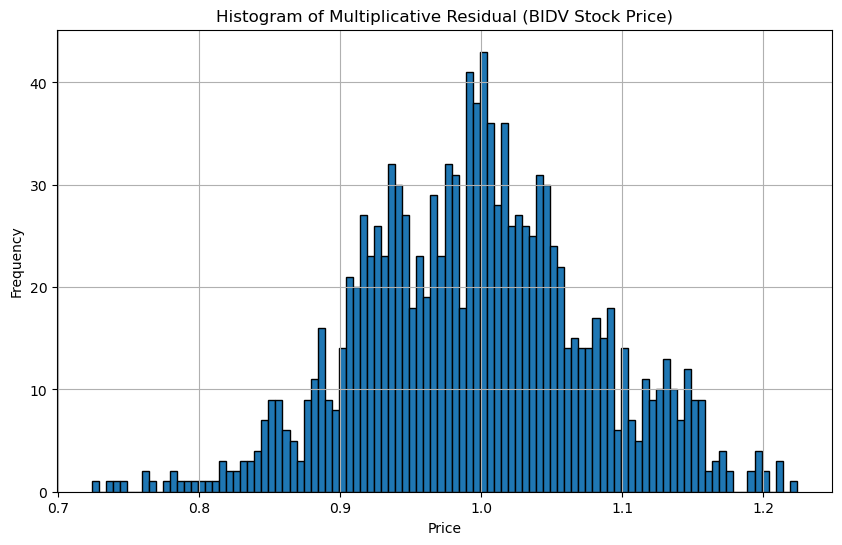

Normality Test Result for Multiplicative Residual (BIDV Stock Price):
Statistic: 0.2127
P-value: 0.8991
The null hypothesis of normality CANNOT BE REJECTED (significant level 0.05).

ADF Test Result for Multiplicative Residual (BIDV Stock Price):
ADF Statistic: -4.342325454663813
p-value: 0.00037493192413702456
The null hypothesis of non-stationarity is REJECTED (significant level 0.05).


In [290]:
plot(series=pd.Series(multiplicative_residuals), series_name='Multiplicative Residual (BIDV Stock Price)')
histogram_plot(series=multiplicative_residuals, series_name='Multiplicative Residual (BIDV Stock Price)')

_ = normal_test(multiplicative_residuals, 'Multiplicative Residual (BIDV Stock Price)', significance_level=0.05)
print()
_ = adf_test(multiplicative_residuals, 'Multiplicative Residual (BIDV Stock Price)', significance_level=0.05)

**Nhận xét:** Về phần dư sau khi phân tích nhân (multiplicative decomposition)
- Biểu đồ **sequence plot**: Tính ngẫu nhiên thấp, giá trị trung bình thay đổi nhiều, phương sai thay đổi ít theo thời gian.
- Biểu đồ **histogram**: Tương đối xấp xỉ phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value` cao; với mức ý nghĩa 0.05 ta không thể bác bỏ giả thuyết về phân phối chuẩn. Tạm kết luận: xấp xỉ phân phối chuẩn, nên thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` rất thấp; dễ dàng bác bỏ giả thuyết về tính không dừng (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: thỏa mãn tính dừng.
- Kết hợp các đánh giá trên, ta kết luận ***phần dư sau khi áp dụng phép phân tích nhân của time series giá cổ phiếu của ngân hàng BIDV `có` thỏa mãn tính dừng***.

#### **3.3. Log Transformation**

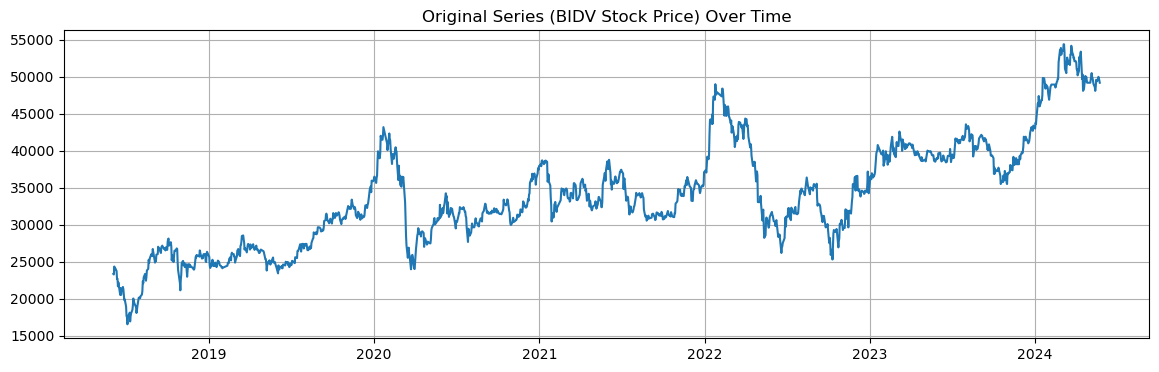

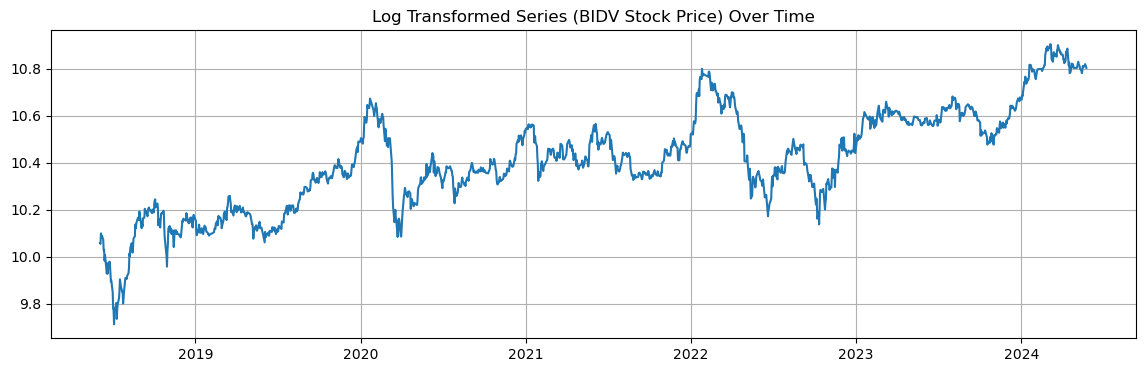

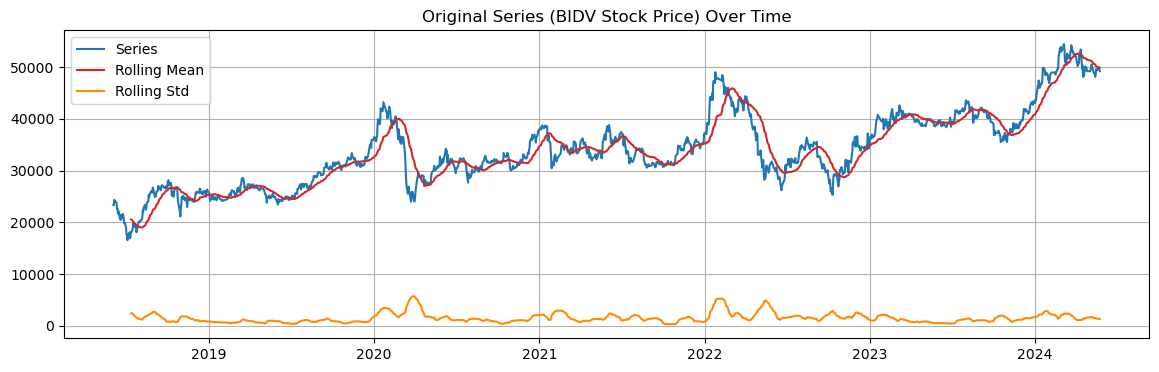

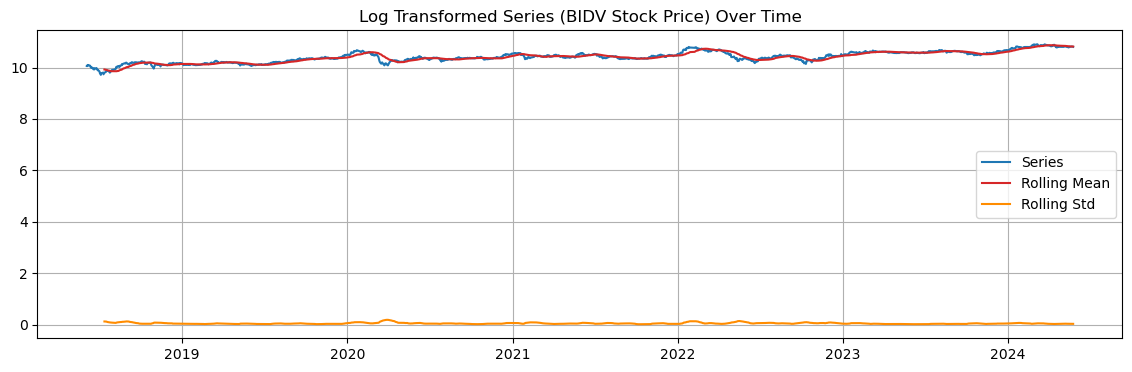

In [291]:
# Thực hiện log transformation
log_transformed_series = np.log(BID_df['Price'])

plot(series=BID_df['Price'], series_name = 'Original Series (BIDV Stock Price)', plots_mean_std=False)
plot(series=log_transformed_series, series_name = 'Log Transformed Series (BIDV Stock Price)', plots_mean_std=False)
plot(series=BID_df['Price'], series_name = 'Original Series (BIDV Stock Price)', plots_mean_std=True)
plot(series=log_transformed_series, series_name = 'Log Transformed Series (BIDV Stock Price)', plots_mean_std=True)

**Pattern sau khi biến đổi không thay đổi nhiều, chỉ có khoảng giá trị thay đổi, do đó làm cho giá trị trung bình và độ lệch chuẩn thay đổi nhỏ hơn.**

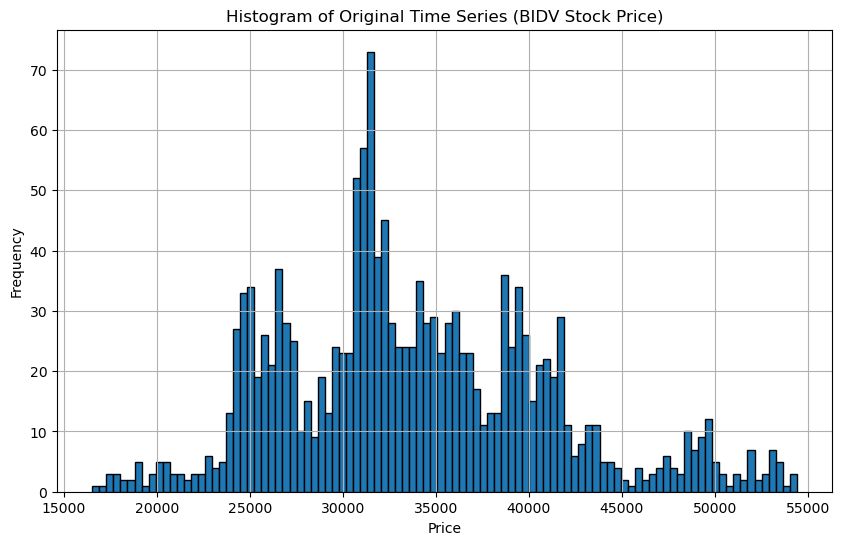

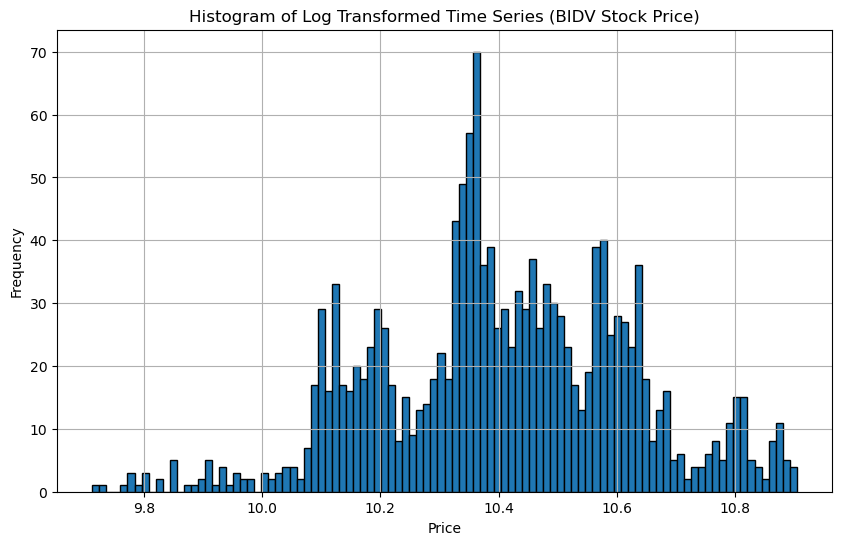

Normality Test Result for Original Time Series:
Statistic: 52.7951
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).

Normality Test Result for Log Transformed Time Series:
Statistic: 3.2166
P-value: 0.2002
The null hypothesis of normality CANNOT BE REJECTED (significant level 0.05).


In [292]:
histogram_plot(series=BID_df['Price'], series_name='Original Time Series (BIDV Stock Price)')
histogram_plot(series=log_transformed_series, series_name='Log Transformed Time Series (BIDV Stock Price)')


_ = normal_test(series=BID_df['Price'], series_name='Original Time Series', significance_level=0.05)
print()
_ = normal_test(series=log_transformed_series, series_name='Log Transformed Time Series', significance_level=0.05)


**Hình dạng biểu đồ histogram của time series sau khi biến đổi có thay đổi nhưng không quá nhiều. Tuy nhiên kết quả kiểm định lại có sự tăng đáng về về `p-value`.**

In [293]:
_ = adf_test(series=log_transformed_series, series_name='Log Transformed Time Series', significance_level=0.05) 

ADF Test Result for Log Transformed Time Series:
ADF Statistic: -1.9589796829708404
p-value: 0.3048434802949833
The null hypothesis of non-stationarity CANNOT BE REJECTED (significant level 0.05).


**Nhận xét:** Về time series sau khi biến đổi log (log transformation)
- Biểu đồ **sequence plot**: Tính ngẫu nhiên thấp, giá trị trung bình thay và phương sai thay đổi nhỏ theo thời gian (vì khoảng giá trị giảm đi).
- Biểu đồ **histogram**: Có độ tương đồng khá thấp với hình dạng phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value` không quá thấp; với mức ý nghĩa 0.05 ta không thể bác bỏ giả thuyết về phân phối chuẩn. Tạm kết luận: xấp xỉ phân phối chuẩn, nên thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` không quá thấp; với mức ý nghĩa 0.05 không thể bác bỏ giả thuyết về tính không dừng. Tạm kết luận: không thỏa mãn tính dừng.
- Kết hợp các đánh giá trên, ta kết luận ***time series giá cổ phiếu của ngân hàng BIDV sau khi biến đổi log `không` thỏa mãn tính dừng***.

#### **3.4. First Order Differencing**

Phép differencing  bậc 1, hay **First Order Differencing** trên một time series là phép biến đổi time series $X(t)$ bằng cách trừ cho $X(t-1)$:
$$
\hat{X}(t) = X(t) - X(t-1).
$$

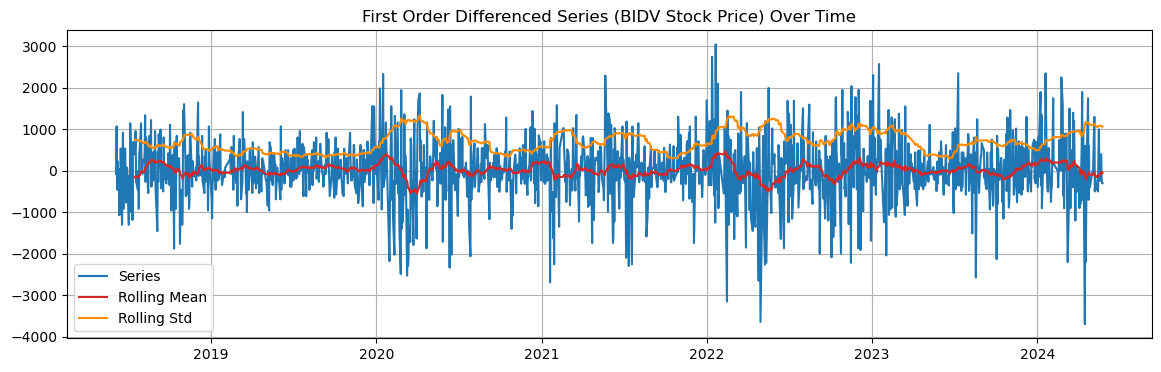

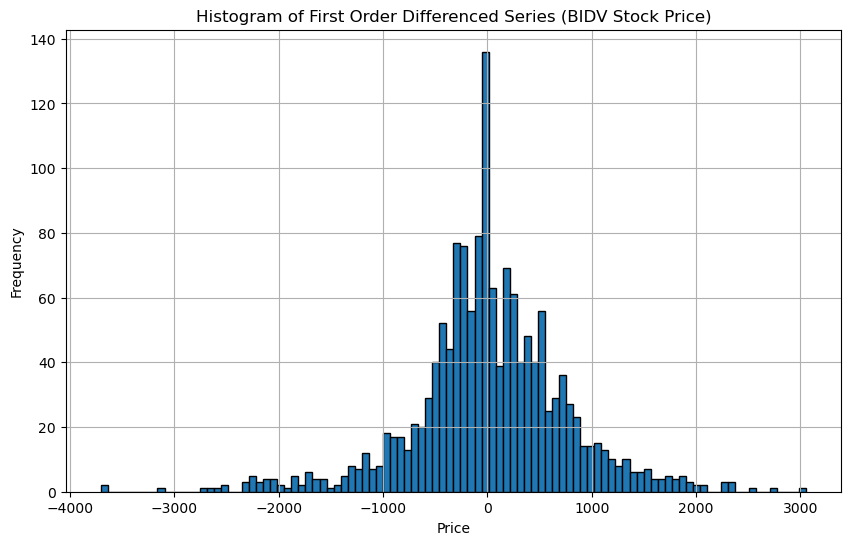

Normality Test Result for First Order Differenced Series (BIDV Stock Price):
Statistic: 110.0386
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).

ADF Test Result for First Order Differenced Series (BIDV Stock Price):
ADF Statistic: -40.03019941251395
p-value: 0.0
The null hypothesis of non-stationarity is REJECTED (significant level 0.05).


In [294]:
# Thực hiện differencing bậc 1
diff_series = BID_df['Price'].diff()
diff_series = drop_na(diff_series)

plot(series=diff_series, series_name='First Order Differenced Series (BIDV Stock Price)')
histogram_plot(series=diff_series, series_name='First Order Differenced Series (BIDV Stock Price)')

_ = normal_test(series=diff_series, series_name='First Order Differenced Series (BIDV Stock Price)', significance_level=0.05)
print()
_ = adf_test(series=diff_series, series_name='First Order Differenced Series (BIDV Stock Price)', significance_level=0.05)

**Nhận xét:** Về time series sau khi áp dụng differencing bậc 1
- Biểu đồ **sequence plot**: Tính ngẫu nhiên cao, giá trị trung bình thay đổi tương đối, phương sai thay đổi tương đối theo thời gian.
- Biểu đồ **histogram**: Không xấp xỉ phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value` rất thấp; dễ dàng bác bỏ giả thuyết về phân phối chuẩn (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: không xấp xỉ phân phối chuẩn, nên không thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` rất thấp; dễ dàng bác bỏ giả thuyết về tính không dừng (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: thỏa mãn tính dừng.
- Kết hợp các đánh giá trên, ta kết luận ***time series về giá cổ phiếu của ngân hàng BIDV sau khi áp dụng differencing bậc 1 `không` thỏa mãn tính dừng***.

#### **3.5. Second Order Differencing**

Phép differencing  bậc 2 có được khi thực hiện 2 phép differencing bậc 1 lần lượt.

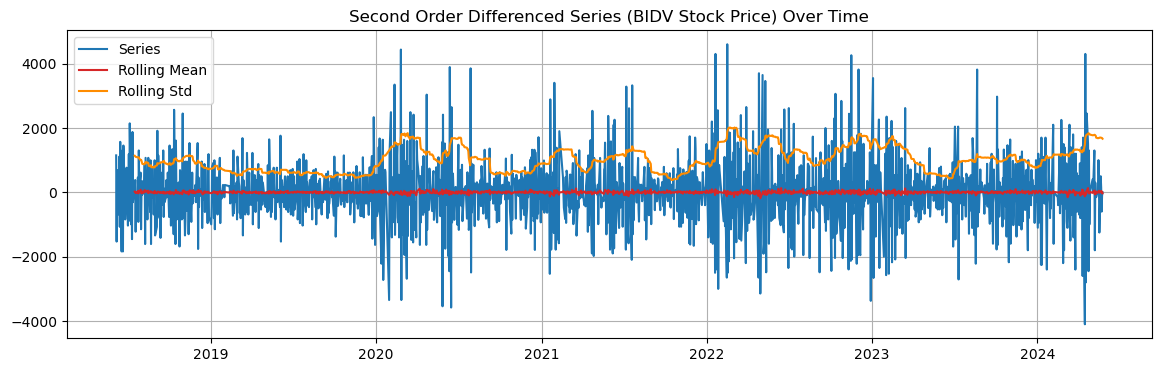

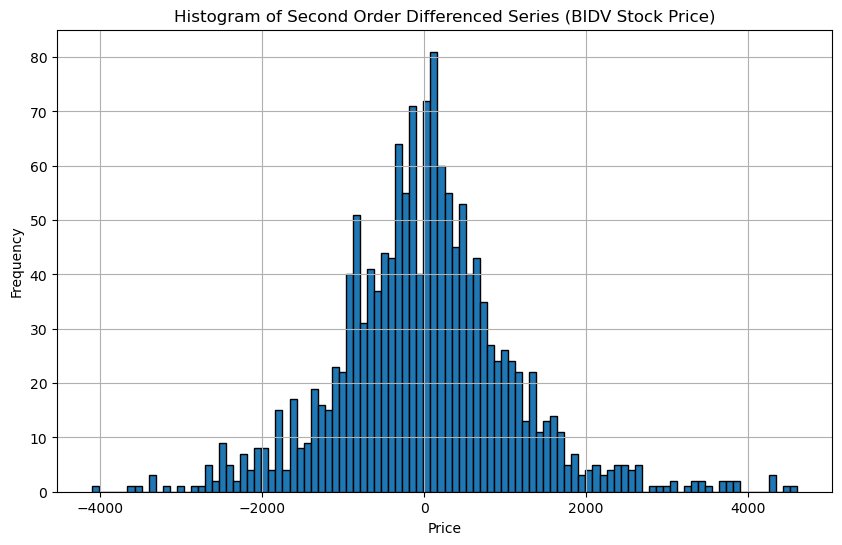

Normality Test Result for Second Order Differenced Series (BIDV Stock Price):
Statistic: 88.2595
P-value: 0.0000
The null hypothesis of normality is REJECTED (significant level 0.05).

ADF Test Result for Second Order Differenced Series (BIDV Stock Price):
ADF Statistic: -14.311965721608388
p-value: 1.1801448762817813e-26
The null hypothesis of non-stationarity is REJECTED (significant level 0.05).


In [295]:
# Thực hiện differencing bậc 2
diff_diff_series = diff_series.diff()
diff_diff_series = drop_na(diff_diff_series)

plot(series=diff_diff_series, series_name='Second Order Differenced Series (BIDV Stock Price)')
histogram_plot(series=diff_diff_series, series_name='Second Order Differenced Series (BIDV Stock Price)')
_ = normal_test(series=diff_diff_series, series_name='Second Order Differenced Series (BIDV Stock Price)', significance_level=0.05)
print()
_ = adf_test(series=diff_diff_series, series_name='Second Order Differenced Series (BIDV Stock Price)', significance_level=0.05)

**Nhận xét:** Về time series sau khi áp dụng differencing bậc 2
- Biểu đồ **sequence plot**: Tính ngẫu nhiên cao, giá trị trung bình không đổi, phương sai thay đổi tương đối theo thời gian.
- Biểu đồ **histogram**: Có sự tương đồng khá thấp với hình dạng phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value`rất thấp; dễ dàng bác bỏ giả thuyết về phân phối chuẩn (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: không xấp xỉ phân phối chuẩn, nên không thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` thấp; dễ dàng bác bỏ giả thuyết về tính không dừng (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: thỏa mãn tính dừng. 
- **Ở đây ta nhận thấy điểm yếu của kiểm định ADF trong trường hợp phương sai thay đổi thì nó có thể không phát hiện được.** (hiện tượng heteroskedasticity)
- Kết hợp các đánh giá trên, ta kết luận ***time series về giá cổ phiếu của ngân hàng BIDV sau khi áp dụng differencing bậc 2 `không` thỏa mãn tính dừng***.

#### **3.6. Seasonal Differencing**

Phép **Seasonal Differencing** trên một time series là phép biến đổi time series $X(t)$ bằng cách trừ cho $X(t-L)$:
$$
\hat{X}(t) = X(t) - X(t-L)
$$
với $L$ là độ dài chu kỳ.

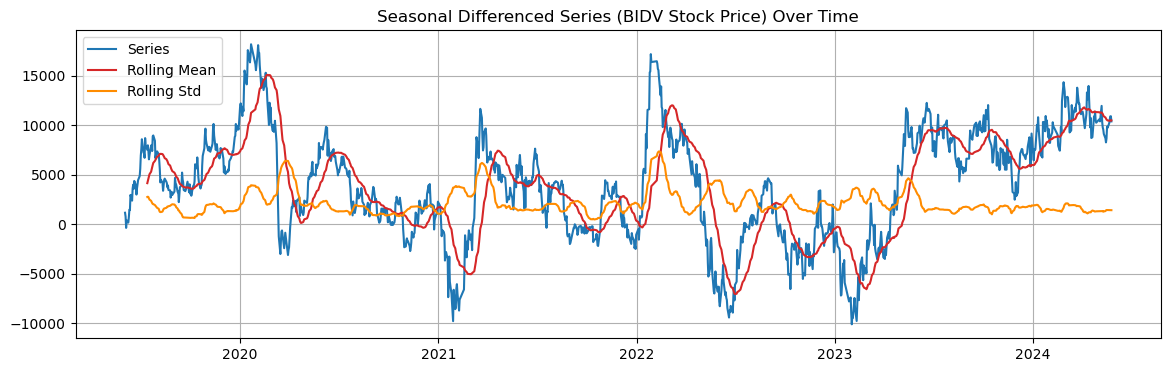

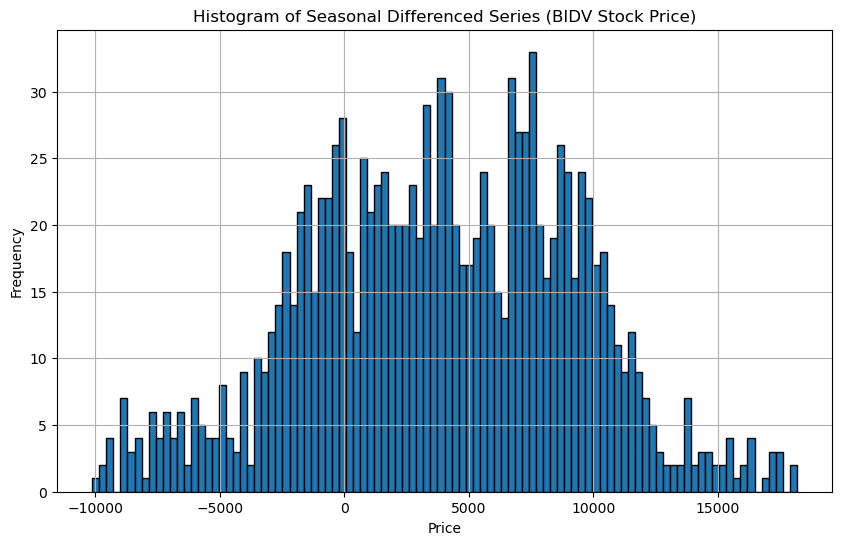

Normality Test Result for Seasonal Differenced Series (BIDV Stock Price):
Statistic: 9.5175
P-value: 0.0086
The null hypothesis of normality is REJECTED (significant level 0.05).

ADF Test Result for Seasonal Differenced Series (BIDV Stock Price):
ADF Statistic: -3.914585532116467
p-value: 0.001930089576978262
The null hypothesis of non-stationarity is REJECTED (significant level 0.05).


In [296]:
# Thưc hiện Seasonal Differencing
seasonal_diff_series = BID_df['Price'].diff(249)
seasonal_diff_series = drop_na(seasonal_diff_series)

plot(series=seasonal_diff_series, series_name='Seasonal Differenced Series (BIDV Stock Price)')
histogram_plot(series=seasonal_diff_series, series_name='Seasonal Differenced Series (BIDV Stock Price)')
_ = normal_test(series=seasonal_diff_series, series_name='Seasonal Differenced Series (BIDV Stock Price)', significance_level=0.05)
print()
_ = adf_test(series=seasonal_diff_series, series_name='Seasonal Differenced Series (BIDV Stock Price)', significance_level=0.05)

**Nhận xét:** Về time series sau khi áp dụng seasonal differencing (chu kỳ 249 ngày)
- Biểu đồ **sequence plot**: Tính ngẫu nhiên thấp, giá trị trung bình thay đổi tương đối, phương sai thay đổi tương đối theo thời gian.
- Biểu đồ **histogram**: Xấp xỉ phân phối chuẩn.
- Kiểm định **normal test**: Giá trị `p-value` khá thấp; dễ dàng bác bỏ giả thuyết về phân phối chuẩn (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: không xấp xỉ phân phối chuẩn, nên không thỏa mãn tính dừng.
- Kiểm định **adf test**: Giá trị `p-value` rất thấp; dễ dàng bác bỏ giả thuyết về tính không dừng (ví dụ chọn mức ý nghĩa 0.05). Tạm kết luận: thỏa mãn tính dừng.
- Kết hợp các đánh giá trên, ta kết luận ***time series về giá cổ phiếu của ngân hàng BIDV sau khi áp dụng seasonal differencing `không` thỏa mãn tính dừng***.

#### **Nhận xét chung:**
- Phần dư sau khi áp dụng phân tích cộng và phân tích nhân thỏa mãn tính dừng, tuy nhiên tính ngẫu nhiên thấp.
- Time series sau khi biến đổi log không thỏa mãn tính dừng, tính ngẫu nhiên thấp.
- Time series sau khi áp dụng differencing bậc 1 không thỏa mãn tính dừng, tính ngẫu nhiên cao.
- Time series sau khi áp dụng differencing bậc 2 không thỏa mãn tính dừng, tính ngẫu nhiên cao. ADF test không phát hiện được heteroskedasticity.
- Time series sau khi áp dụng seasonal differencing không thỏa mãn tính dừng, tính ngẫu nhiên thấp. ADF test không phát hiện được heteroskedasticity.

### **4. Xây dựng mô hình SARIMA và mô hình LSTM để dự đoán giá cổ phiếu.**


##### **Thông tin đang quan tâm:**
- Xây dựng các mô hình dự đoán giá cổ phiếu của ngân hàng BIDV.
- Đánh giá độ chính xác của các mô hình đã xây dựng.

##### **Hướng tiếp cận:**
- Lấy ra time series về giá cổ phiếu `Price` của ngân hàng BIDV.
- Chia time series thành 2 phần: phần `train_set` để xây dựng mô hình, phần `test_set` để dự đoán và đánh giá độ chính xác của mô hình.
- Các mô hình dự đoán sẽ xây dựng: SARIMA (sử dụng `auto_arima`), LSTM (sử dụng thư viện `Keras`).

#### **4.1. Mô hình SARIMA**

Để hiểu được mô hình SARIMA, chúng ta cần đi qua các các mô hình đơn giản hơn. Ở đây chúng ta sẽ điểm qua các mô hình AR, MA, ARMA, từ đó hiểu về SARIMA. 

**Mô hình Autoregressive (AR):** Mô hình AR(p) là một mô hình time series trong đó sử dụng p giá trị trong quá khứ để xây dựng một phương trình hồi quy có thể dự đoán giá trị hiện tại. 
$$
X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + ... + \phi_p X(t-p) + \epsilon_t
$$ 
với
- $X(t)$: Giá trị của time series tại thời điểm $t$.
- $c$: Hằng số.
- $\phi_1, \phi_2,..., \phi_p$: Các hệ số của mô hình.
- $p$: Order của mô hình AR (độ trễ hay số giá trị trong quá khứ để dựa đoán giá trị tiếp theo).
- $\epsilon_t$: White noise tại thời điểm $t$.

Giả định: Time series thỏa mãn tính dừng.
Cách chọn order cho mô hình AR: Quan sát biểu đồ PACF và chọn độ trễ mà tại đó giá trị của hàm PACF ngoài khoảng tin cậy, tức giá trị tương quan riêng phần PACF có ý nghĩa thống kê. 

**Mô hình Moving Average (MA):** Mô hình MA(q) là một mô hình time series trong đó sử dụng q giá trị phần lỗi `error term` (hay phần dư `residual`, nhiễu trắng `white noise`) của time series xây dựng một phương trình hồi quy có thể dự đoán giá trị hiện tại.

$$
    X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ...+ \theta_p \epsilon_{t-q} 
$$

với
- $X(t)$ là time series tại thời điểm $t$.
- $\mu$ là giá trị trung bình của series.
- $\theta_1, \theta_2,...,\theta_q$ là các hệ số của mô hình.
- $q$ là order của mô hình (độ trễ hay số giá trị phần lỗi trong quá khứ để dựa đoán giá trị tiếp theo).
- $\epsilon_t$ là giá trị phần lỗi (nhiễu trắng) tại thời điểm $t$.

Giả định: Time series thỏa mãn tính dừng.
Cách chọn order cho mô hình MA: Quan sát biểu đồ ACF và chọn độ trễ mà tại đó giá trị của hàm ACF ngoài khoảng tin cậy, tức giá trị tương quan ACF có ý nghĩa thống kê. 

**Mô hình ARMA:** Mô hình ARMA(p,q) (Auto Regressive Moving Average) kết hợp mô hình AR(p) và MA(q) như đã trình bày ở trên. Giả định: Time series thỏa mãn tính dừng.

**Mô hình ARIMA:** Mô hình ARIMA(p,d,q) (Auto Regressive Integrated Moving Average) là mở rộng của mô hình ARMA, bao gồm 3 thành phần: mô hình AR(p), integrated component và mô hình MA (q). Integrated component là thành phần thực hiện differencing bậc d (có thể hiểu là differencing d lần) time series để giúp time series thỏa mãn tính dừng. 

**Mô hình SARIMA:** Mô hình SARIMA(p,d,q)x(P,D,Q,s) (Seasonal Auto Regressive Integrated Moving Average) là mở rộng của mô hình ARIMA, bao gồm 2 thành phần: thành phần ARIMA thuần (p,d,q) và thành phần chu kỳ (P,D,Q,s) với P là seasonal autoregressive order (xác định bởi PACF plot), Q là seasonal differencing order (số lần seasonal differencing cần thực hiện để giúp time series thỏa mãn tính dừng), Q là seasonal moving average order (xác định bởi ACF plot), s là độ dài một chu kỳ.

> **Chú ý:**
> 1. Việc lựa chọn các tham số cho mô hình SARIMA rất phức tạp và đòi hỏi nhiều kinh nghiệm. Ta cần thực hiện tìm ra độ dài chu kỳ, thử các phương pháp detrend, differencing, seasonal differencing với các bậc khác nhau, đánh giá ACF và PACF plot... Ở trong câu hỏi này, để đơn giản, chúng ta sẽ sử dụng `auto_arima` để xây dựng mô hình dự đoán SARIMA một cách tự động. 
> 2. Khi xây dựng mô hình SARIMA, dù thủ công hay tự động, ta đều phải xác định độ dài của chu kỳ. Ở câu 2, ta đã sử dụng kỹ thuật FFT để tìm độ dài mỗi chu kỳ của time series về giá cổ phiếu của ngân hàng BIDV là khoảng 249 ngày. Tuy nhiên, khi thực hiện auto_arima với độ dài chu kỳ lớn thì dễ gặp lỗi cấp phát vùng nhớ. Do đó, ở trong ví dụ dưới đây, ta chọn độ dài chu kỳ là 30. Tuy nhiên việc chọn tham số chu kỳ không phù hợp có thể khiến mô hình đưa ra những dự đoán không chính xác.   

Mã nguồn bên dưới được tham khảo từ notebook [Microsoft Stock Price Prediction](https://www.kaggle.com/code/paramarthasengupta/microsoft-stocks-price-prediction) của tác giả Paramartha Sengupta.



In [297]:
BID_df_4 = get_bank_df(bankname='BIDV', date_index=False)

In [298]:
from math import floor,ceil
from pmdarima.arima import auto_arima

def auto_arima_prediction(df, m=30, train_ratio=0.75, trace=True):
    # Chuẩn bị dữ liệu
    shape = df.shape[0]
    df_new = df.copy()
    data = df_new.sort_index(ascending=True, axis=0)
    
    # Chia dataframe theo tỉ lệ tập train và tập validation
    train_df = data[:ceil(shape * train_ratio)]
    valid_df = data[ceil(shape * train_ratio):]
    
    print('----------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set:', train_df.shape)
    print('Shape of Validation Set:', valid_df.shape)
    
    # Tập train
    train_series = train_df['Price']
    
    # Khởi tạo mô hình SARIMA
    model = auto_arima(
        train_series, 
        start_p=1, start_q=1, 
        max_p=2, max_q=2, 
        m=m, start_P=0, 
        seasonal=True, 
        d=1, D=1, 
        trace=trace, 
        error_action='ignore', 
        suppress_warnings=True
    )

    # Huấn luyện mô hình
    model.fit(train_series)
    
    # Dự đoán trên tập validation
    forecast = model.predict(n_periods=ceil(shape * (1 - train_ratio)))
    forecast = pd.DataFrame(forecast, index=valid_df.index, columns=['Prediction'])
    
    # Tính độ lỗi RMSE
    rms = np.sqrt(np.mean(np.power((np.array(valid_df['Price']) - np.array(forecast['Prediction'])), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Trực quan kết quả dự đoán
    plt.figure(figsize=(10, 6))
    plt.plot(train_df['Price'], label='Model Train_series Data')
    plt.plot(valid_df['Price'], label='Actual Data')
    plt.plot(forecast['Prediction'], label='Predicted Data')
    plt.xlabel('Date', size=10)
    plt.ylabel('Price', size=10)
    plt.title('Stock Price Prediction by Auto ARIMA', size=20)
    plt.legend()
    plt.show()

    # Trả về độ lỗi trên tập validation
    return rms

----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1345, 9)
Shape of Validation Set: (149, 9)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=5.91 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=21955.423, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=21641.424, Time=5.58 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=6.50 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=21956.164, Time=0.40 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=21511.957, Time=16.39 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=24.63 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=7.04 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=21511.628, Time=4.14 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=21640.046, Time=1.96 sec
 ARIMA(0,1,0)(2,1,1)[30]             : AIC=inf, Time=18

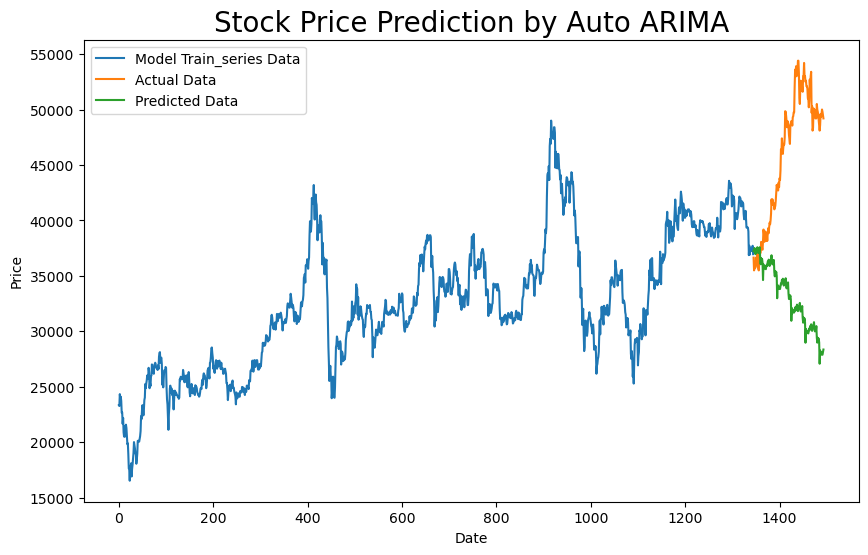

In [299]:
loss_sarima = auto_arima_prediction(BID_df_4, m=30, train_ratio=0.9)

----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set: (1420, 9)
Shape of Validation Set: (74, 9)
RMSE value on validation set: 4870.24606824203
-----------------------------------------------------------
-----------------------------------------------------------


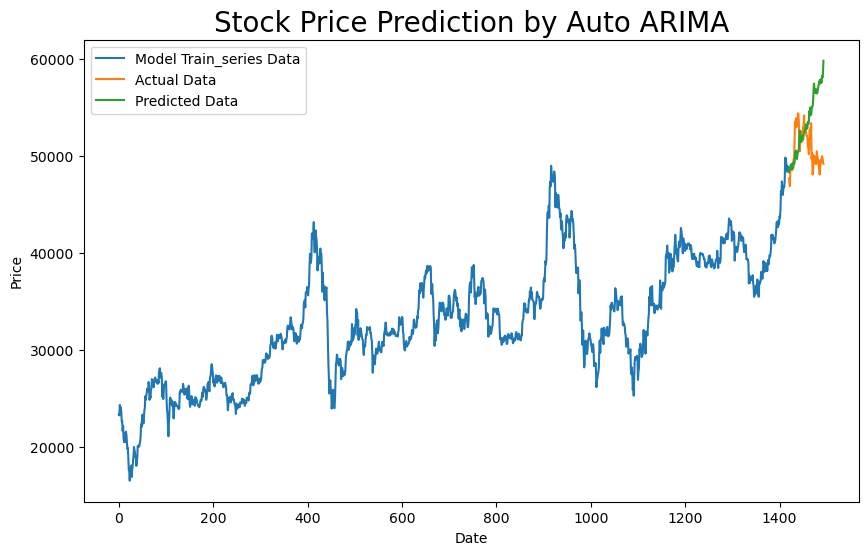

4870.24606824203

In [300]:
auto_arima_prediction(BID_df_4, train_ratio=0.95, m=30, trace=False)

**Nhận xét:**
- Từ biểu đồ trực quan, ta thấy kết quả dự đoán của mô hình có sự khác biệt lớn so với giá trị thực tế, không khớp với sự biến động xu hướng trong time series. Nguyên nhân phần lớn là do chu kỳ lựa chọn trong mô hình (30) không đúng với chu kỳ thực tế (khá dài: 249 ngày, vì time series về giá cổ phiếu thường có sự biến động lớn và thiếu ổn định). Có thể nói việc lựa chọn độ dài chu kỳ phù hợp cho mô hình SARIMA là quan trọng, độ dài chu kỳ sai có thể dẫn đến kết quả dự đoán sai; tuy nhiên nếu chu kỳ quá dài có thể gây khó khăn cho việc xây dựng mô hình.
- Cách dự đoán của mô hình SARIMA khá đơn giản và tập trung vào xu hướng hiện tại, không nắm bắt được nhiều thông tin trong quá khứ dài hạn (quan tâm short-term memory nhiều hơn so với long-term memory). 
- Việc sử dụng auto arima tốn kém và thiếu những đánh giá chất lượng về dữ liệu. Tuy nhiên để lựa chọn được các tham số của mô hình SARIMA một cách thủ công - như đã nói - khá phức tạp và đòi hỏi nhiều kinh nghiệm.

#### **4.2. Mô hình LSTM**

**Long Short Term Memory (LSTM):** LSTM là một loại kiến trúc Recurrent Neural Network (RNN) nhằm giải quyết vấn đề vanishing gradient của mô hình RNN truyền thống khi giải quyết các bài toán dạng chuỗi có gap length lớn (hay nói cách khác là có long-term dependencies). 

Một trong những ứng dụng phổ biến của LSTM đó là dự đoán time series. Ở đây, chúng ta không đi chi tiết vào LSTM vì nó đòi hỏi trình bày nhiều kiến thức về học sâu - nằm ngoài nội dung của môn học và mục tiêu của đồ án. Vì vậy, ta tập trung vào việc sử dụng kiến trúc LSTM được xây dựng sẵn bởi một high-level framework là `Keras` để có thể thực hiện dự đoán.

Mã nguồn bên dưới được tham khảo từ notebook [Microsoft Stock Price Prediction](https://www.kaggle.com/code/paramarthasengupta/microsoft-stocks-price-prediction) của tác giả Paramartha Sengupta.

In [301]:
! pip install TensorFlow

In [302]:
! pip install tf_keras

In [303]:
from sklearn.preprocessing import MinMaxScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM
from math import ceil, sqrt

# Tắt warning của TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def lstm_prediction(df, train_ratio=0.75, epochs=1):
    window_size = 40
    # Đảm bảo số mẫu trong dữ liệu lớn hơn window size
    if df.shape[0] < window_size:
        print("Not enough data to train the model. Need at least window_size data points.")
        return

    # Chuẩn bị dữ liệu
    df_new = df[['Price']]
    dataset = df_new.values
    train_size = ceil(df.shape[0] * 0.75)
    
    # Chia dataframe theo tỉ lệ tập train và tập validation
    train = df_new[:train_size]
    valid = df_new[train_size:]
    
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set:', train.shape)
    print('Shape of Validation Set:', valid.shape)
    
    # Scale dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    # Chuẩn bị dữ liệu train
    x_train, y_train = [], []
    for i in range(window_size, len(train)):
        x_train.append(scaled_data[i-window_size:i, 0])
        y_train.append(scaled_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Xây dựng mô hình LSTM
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        LSTM(units=50),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Huấn luyện mô hình
    model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=2)
    
    # Chuẩn bị dữ liệu validate
    inputs = df_new[len(df_new) - len(valid) - window_size:].values
    inputs = scaler.transform(inputs.reshape(-1, 1))
    
    x_validate = []
    for i in range(window_size, inputs.shape[0]):
        x_validate.append(inputs[i-window_size:i, 0])
    x_validate = np.array(x_validate)
    x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], 1))
    
    # Dự đoán
    predicted_price = model.predict(x_validate)
    predicted_price = scaler.inverse_transform(predicted_price)
    
    # Tính độ lỗi RMSE
    rms = sqrt(np.mean(np.power((valid.values - predicted_price), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Trực quan kết quả dự đoán
    valid['Predictions'] = predicted_price
    plt.figure(figsize=(16, 8))
    plt.plot(train['Price'], label='Train')
    plt.plot(valid['Price'], label='Valid')
    plt.plot(valid['Predictions'], label='Prediction')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
    plt.legend()
    plt.show()

    # Trả về độ lỗi trên tập validation
    return rms

Ta huấn luyện mô hình LSTM qua 10 epochs:

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1121, 1)
Shape of Validation Set: (373, 1)
Epoch 1/10
1081/1081 - 12s - loss: 0.0030 - 12s/epoch - 11ms/step
Epoch 2/10
1081/1081 - 8s - loss: 0.0011 - 8s/epoch - 7ms/step
Epoch 3/10
1081/1081 - 8s - loss: 9.4598e-04 - 8s/epoch - 7ms/step
Epoch 4/10
1081/1081 - 8s - loss: 7.4465e-04 - 8s/epoch - 7ms/step
Epoch 5/10
1081/1081 - 8s - loss: 6.5685e-04 - 8s/epoch - 7ms/step
Epoch 6/10
1081/1081 - 8s - loss: 5.9176e-04 - 8s/epoch - 7ms/step
Epoch 7/10
1081/1081 - 8s - loss: 6.3219e-04 - 8s/epoch - 7ms/step
Epoch 8/10
1081/1081 - 7s - loss: 6.4831e-04 - 7s/epoch - 7ms/step
Epoch 9/10
1081/1081 - 8s - loss: 5.4976e-04 - 8s/epoch - 7ms/step
Epoch 10/10
1081/1081 - 8s - loss: 5.4469e-04 - 8s/epoch - 7ms/step
12/12 [==========================

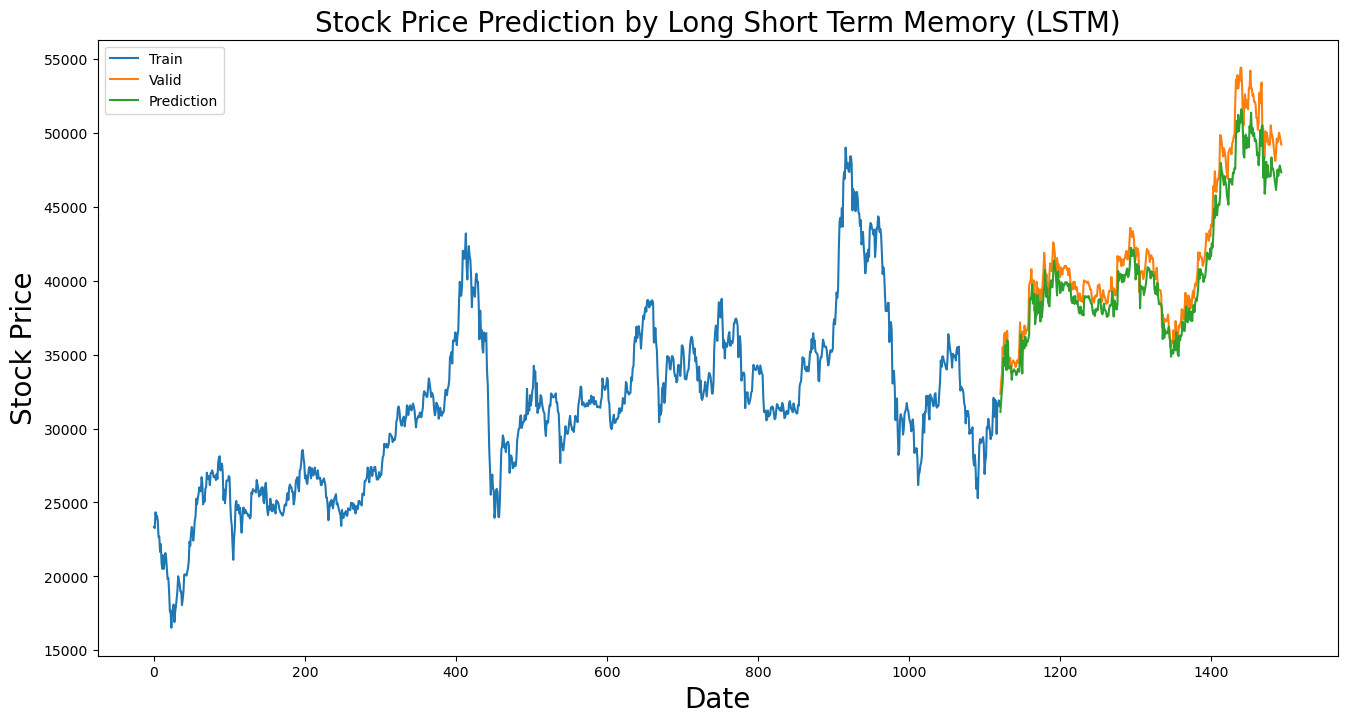

In [304]:
loss_lstm = lstm_prediction(BID_df_4, train_ratio=0.9, epochs=10)

**Kết quả dự đoán của mô hình LSTM tốt hơn nhiều và gần như rất khớp với time series. Độ lỗi của mô hình này so với mô hình SARIMA bên trên giảm đáng kể.**

In [305]:
print('Loss of LSTM after 10 epochs over SARIMA (on Validation Set):', loss_lstm / loss_sarima) 

Loss of LSTM after 10 epochs over SARIMA (on Validation Set): 0.10637228435174166


**Ta thử huấn luyện chỉ với 1 epochs để xem mô hình huấn luyện "nhanh" này có tốt hơn SARIMA không:**

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1121, 1)
Shape of Validation Set: (373, 1)
1081/1081 - 11s - loss: 0.0033 - 11s/epoch - 11ms/step
12/12 [==============================] - 1s 5ms/step
RMSE value on validation set: 2058.498564262121
-----------------------------------------------------------
-----------------------------------------------------------


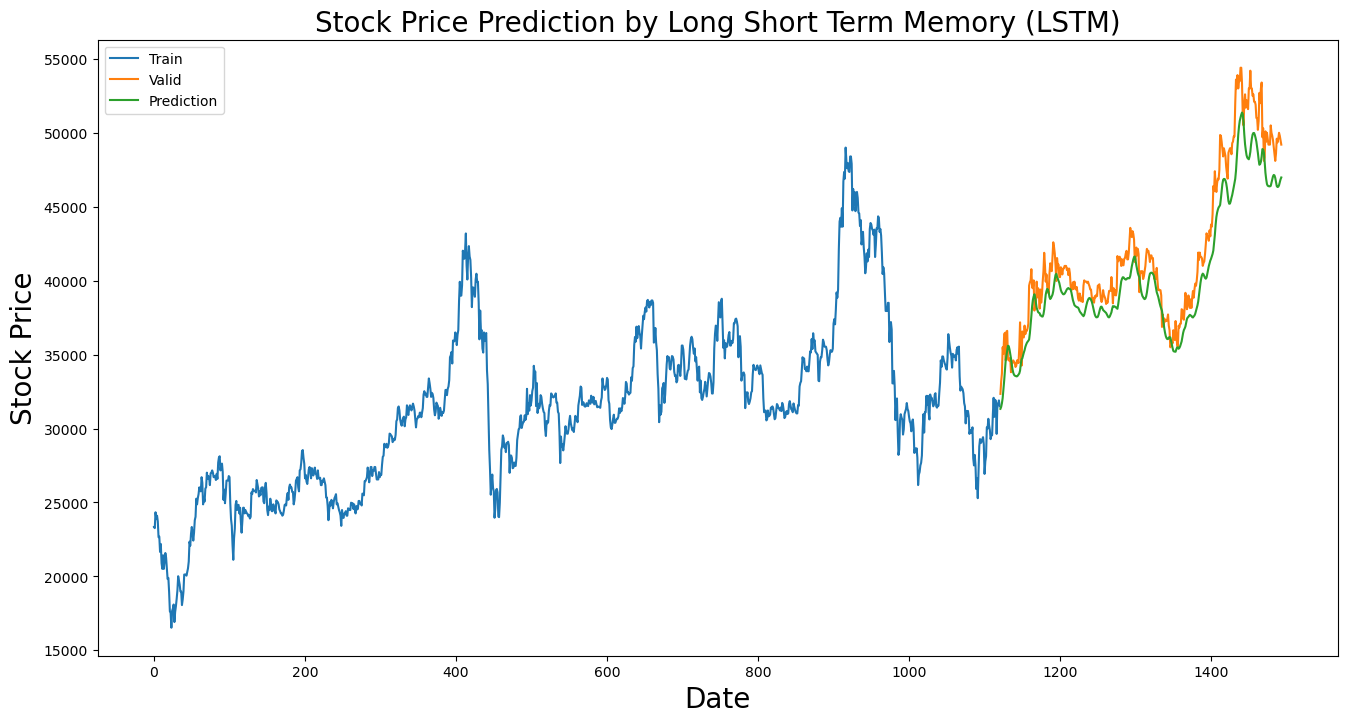

In [306]:
loss_lstm_1 = lstm_prediction(BID_df_4, train_ratio=0.9, epochs=1)

**Dù chỉ huấn luyện qua 1 epoch nhưng mô hình vẫn rất khớp với time series và độ lỗi vẫn thấp hơn nhiều so với mô hình SARIMA phía trên.** 

In [307]:
print('Loss of LSTM after 1 epochs over SARIMA (on Validation Set):', loss_lstm_1 / loss_sarima) 

Loss of LSTM after 1 epochs over SARIMA (on Validation Set): 0.13486069496065722


**Ngoài ra, có thể mô hình phía trên khá overfiting vì độ lỗi trên tập train giảm nhưng độ lỗi trên tập test lại tăng khá nhiều.**

In [308]:
print('Loss of 10-epoch LSTM over 1-epoch LSTM (on Validation Set):', loss_lstm / loss_lstm_1) 

Loss of 10-epoch LSTM over 1-epoch LSTM (on Validation Set): 0.788756756612989


#### **Nhận xét chung:** 
So sánh giữa các mô hình `LSTM` và mô hình `SARIMA` đã xây dựng ở phần trước:
- **Độ khớp của mô hình:** LSTM khớp rất tốt với time series, nắm bắt được những mối quan hệ phức tạp trong dữ liệu. SARIMA không khớp với time series, biểu diễn mô hình đơn giản, tuyến tính.
- **Kết quả dự đoán:** LSTM dự đoán tốt và đúng xu hướng trong tương lai. SARIMA có thể đưa ra dự đoán sai lệch, đặc biệt là khi độ dài chu kỳ được lựa chọn không phù hợp.
- **Độ lỗi:** Độ lỗi của LSTM thấp hơn nhiều so với SARIMA, dù chỉ huấn luyện với số lượng epoch nhỏ.
- **Độ khó khi xây dựng mô hình:** LSTM khá đơn giản để xây dựng mô hình vì mọi tham số đều được học tự động theo cơ chế học sâu. SARIMA yêu cầu chỉ định các tham số của mô hình - khá phức tạp và đòi hỏi nhiều kinh nghiệm. ARIMA tự động (auto arima) giúp giảm sự phức tạp khi lựa chọn tham số của SARIMA nhưng tốn kém (đặc biệt khi độ dài chu kì lớn); có thể không tốt vì thiếu sự đánh giá và hiểu dữ liệu - yếu tố cần thiết để xây dựng một mô hình SARIMA tốt.
- **Mức độ giải thích được của mô hình:** Các mô hình học sâu như LSTM khó giải thích, trong khi đó SARIMA có thể giải thích được. 